last updated 24 03 24

This notebook is to get the run times for each model on the highest and lowest resolutions; to estimate an average run time.IG DICITONARY!



In [1]:
#!pip install ipython

In [2]:
# imports
import torch
import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

from functions import import_imagedata, ImageProcessor, label_oh_tf
from fns4wandb import  set_lossfn
from architectures import sevennet, smallnet1, smallnet2, smallnet3
from loop_fns import loop
from plotting import learning_curve, accuracy_curve, plot_confusion

from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
import time

import csv
import json
import pickle
import os

import wandb

In [3]:
# file paths
_save_location = r'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/7c3l'

data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = '153b7e71c32ca05af0ffa74d692595a689d0a538'

In [4]:
wandb.login()

wandb: Currently logged in as: naughticalnonsence (antvis). Use `wandb login --relogin` to force relogin


True

In [5]:
#!pip install datetime

d = date.today()
#print(str(d), type(str(d)))

452 144               5/452 *100 = 1%
226 72                5/226 *100 = 2%
113 36                5/113 *100 = 4% -- 2/113 *100= 1.7% ~ 2%
57  18   (56.5,)      5/57 *100  = 8% -- 2/57 *100 = 3.5% ~ 4%.   1/57 = 1.75%
29   9   (28.5,)      5/29 *100  = 17% -- 2/29 *100 = 6.89 ~ 7%   1/28 = 3.57 ~ 4%
15   5   (14.5, 4.5)
8    3   (7.5,2.5)
4,   2   (, 1.5)

In [6]:
   

pp = pprint.PrettyPrinter(indent=4)

def save2csv_nest_dict(nested_dict, file_name, save_location:str):
  # flattern nested dictionary
  flatterend_dict = {}
  for k,v in nested_dict.items():
    if isinstance(v, dict):
      for nested_key, nested_val in v.items():
        flatterend_dict[f"{k}_{nested_key}"] = nested_val
    else:
      flatterend_dict[k] =v

  columns = list(flatterend_dict.keys())

  with open(save_location+str(file_name)+'.csv', "a+", newline="") as f:
      # using dictwriter
      writer = csv.DictWriter(f, fieldnames=columns)
      # using writeheader function
      if f.tell() == 0:
        writer.writeheader()
      writer.writerow(flatterend_dict)
      f.close()

# check dictionary values for json and csv

def check_obj4np(obj):
    if isinstance(obj, dict):
        return {key: check_obj4np(value) for key, value in obj.items()}
    if isinstance(obj,list):
        return [check_obj4np(item) for item in obj]
    if isinstance(obj,np.ndarray):
        return obj.tolist()
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    else:
        return obj

# save to json
def save2josn_nested_dict(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    json_obj = json.dumps(nested_dict, indent=4)
    with open(save_location+str(file_name)+'.json', 'a+') as f:
        f.write(json_obj)
        f.close()

    
#save_location+str(file_name)+'.csv'
def save2csv(nested_dict, file_name, save_location:str):
    
    nested_dict = check_obj4np(nested_dict)
    
    columns = list(nested_dict.keys())
    path = os.path.join(save_location, file_name +".csv")
    try:
        with open(path, "a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=columns)
            # using dictwriter
            # using writeheader function
            if f.tell() == 0:
                writer.writeheader()
            writer.writerow(nested_dict)
            f.close()
    except IOError as e:
        print("I/O error({0}): {1}".format(e.errno, e.strerror))
    except ValueError:
              print("could not convert to string")
    except:
              print("unexpected error: ", sys.exc_info()[0])
        

def save2json(nested_dict, file_name, save_location:str):
    nested_dict = check_obj4np(nested_dict)
    #print(nested_dict)
    #print(nested_dict.items())
    json_obj = json.dumps(nested_dict, indent=4)
    #print(json_obj)
    path = os.path.join(save_location, file_name+".json")
    #print(path)
    with open(path, 'w') as f:
        f.write(json_obj)
        
        


def read_in_json(file_path, file_name):
    path = os.path.join(file_path, 'file_name')
    try:
        with open(path, 'r') as f:
            #obj = f.read()
            dj = json.load(f, object_pairs_hook= collections.OrderedDict) #obj, 
            #print(dj)
    except Exception as e:
        print("Error decoding Json")
        print(e)


class Flattern(nn.Module):
    def __init__(self):
        super(Flattern, self).__init__()
    def forward(self, x):
        #print(x.shape)
        x = x.flatten()
        return x


def choose_model(model_name, lin_lay, dropout):

    #for model_card in config.model_cards:
    #print('\n choose_model \n MODEL NAME: ',model_name)

    if model_name == '4c3l':
        return smallnet1(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '3c2l':
        return smallnet2(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks = (3,5), dropout=dropout)
    elif model_name == '2c2l':
        return smallnet3(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == '7c3l':
        return sevennet(in_chan=3, f_lin_lay=int(lin_lay), l_lin_lay=11, ks= (3,5), dropout= dropout)
    elif model_name == 'vgg16':
        model_vgg16 = vgg16(weights="IMAGENET1K_V1")
        vgg_feats = model_vgg16.features
        vgg_classifier = model_vgg16.classifier
        vgg_classifier.pop(6)

        vgg = nn.Sequential(
            vgg_feats,
            Flattern(),
            vgg_classifier,
            nn.Linear(4096,11),
            nn.Softmax(dim=0),
            )
        return vgg
    else:
        print('Model Name Not Recognised')


In [7]:
# dictionaries

date = date.today()

model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                             4096,
                            ],
                 'idx': 0,
                 'dropout':0.2}


model_card_7c3l = {'name': '7c3l', 'model': '7c3l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[248832,    # 452 144    # p5
                            59904,      # 226 72     # p5
                            11264,      # 113  36    # p2
                            1536,       # 57 18      # p1
                            172032,           # 29  9
                            172032,          # 15 5
                            172032,         # 8 3
                              ], 
                   'idx': 1,
                  'dropout':0.2}



model_card_4c3l = {'name': '4c3l', 'model': '4c3l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[539904,    # 452 144    # p5
                             141056,    # 226 72     # p5
                             304640,     # 113  36    # p2
                             9984,      # 57 18      # p1
                             2304,      # 29  9
                             512,       # 15 5
                             256],      # 8 3
                  'idx': 2,
                  'dropout':0.2}      

model_card_3c2l = {'name': '3c2l', 'model': '3c2l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[1069888,    # 452 144    # p5
                             274688,     #226 72      # p5
                             68096,      # 113  36    # p2
                             17280,      # 57 18      # p1
                             3840,       # 29  9
                             960,        # 15 5
                             256],
                  'idx': 3,
                  'dropout':0.2}       # 8 3

model_card_2c2l = {'name': '2c2l', 'model': '2c2l', 'channels': 3, 'ks': (3,5),
                  'f_lin_lay':[1055232,    # 452 144    # p5
                             267264,     #226 72      # p5
                             64512,      # 113  36    # p2
                             15552,      # 57 18      # p1
                             3072,       # 29  9
                             640,        # 15 5
                             128],
                  'idx': 4,
                  'dropout':0.1}       # 8 3

resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



resolution_cards = [resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,
                    resolution_card_299, resolution_card_155, resolution_card_83]
#resolution_cards = [resolution_card_11336]

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards =  [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [0.0001, 6e-5, 7e-5, 8e-5,9.76E-05]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
scheduler_cards = [0, 0.1, 0.2]

seeds = [8,2,3] # 4, 5,6

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_7c3l]

loss_fn_cards = ['CrossEntropy'] #'MSE', 
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler_cards':scheduler_cards})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


#print(model_card_vgg)
#print('')
#pp.pprint(config) # dictionary of dictionaries of lists and lists of dictionaries

In [8]:

def train_val(model, x_train, x_val, y_train, y_val, res, pad, save_dict, lr, loss_fn, epochs,optimizer, scheduler_value,model_name, av_lum): #train_dl, val_dl, 


    
    #optimizer = torch.optim.Adam(model.parameters(), lr=lr)#build_optimizer(mo
    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value) 
    #scheduler'
    ####
    
    #model = model.to(device)
    model.train()
    
    
    #losses= []
    #predictions = []
    t_loss_list = []
    v_loss_list = []
    t_predict_list = []
    v_predict_list = []
    t_accuracy_list = []
    v_accuracy_list = []
    t_label_list = []
    v_label_list = []
    #labels = []

    
    total_epochs = 0
    for epoch in tqdm(range(epochs)):

        #print('Training...')
    
        t_loss, train_prediction, t_correct, model, optimizer = loop(model=model, X=x_train, Y=y_train, loss_fn=loss_fn, device=device, 
                                                                     size= res,  pad=pad, num_classes=11, model_name= model_name, av_lum=av_lum,
                                                                     optimizer=optimizer) #,   scheduler =scheduler
        
        t_loss_list.append(t_loss)
        t_predict_list.append(train_prediction)
        wandb.log({'t_loss':t_loss})
        #wandb.log({'t_predict_list':train_prediction})
        #wandb.log({'train_labels':list(y_train)})
        train_acc = (t_correct/len(x_train)*100)
        #print('train accuracy: ', train_acc )
        t_accuracy_list.append(train_acc)
        wandb.log({'train_acc':train_acc})
        #y_train_save = y_train.tolist()

        
        #clear_output()
        
            
        #print('validating...')
        
        v_loss, val_prediction, val_correct= loop(model=model, X=x_val, Y=y_val, loss_fn=loss_fn, device=device,
                                                  size= res,  pad=pad, num_classes=11, model_name= model_name, 
                                                  av_lum=av_lum, train=False)
        #
        #scheduler.step()
        v_loss_list.append(v_loss)
        v_predict_list.append(val_prediction)
        wandb.log({'v_loss':v_loss})
        #wandb.log({'v_predict_list':val_prediction})
        #wandb.log({'y_val':list(y_val)})
        val_acc = (val_correct/len(x_val)*100)
        v_accuracy_list.append(val_acc)
        #print('validation accuracy: ', val_acc )
        wandb.log({'val_acc':val_acc})

        #clear_output()
            
        total_epochs += 1
        
    save_dict['Current_Epoch'] = epochs
    save_dict['training_samples'] = len(x_train)
    save_dict['validation_samples'] = len(x_val)

    save_dict['t_accuracy_list'] = t_accuracy_list 
    save_dict['v_accuracy_list'] = v_accuracy_list  #
            
    #model = best_model
    save_dict['t_loss_list'] = t_loss_list
    save_dict['v_loss_list'] = v_loss_list
    
    save_dict['t_labels'] = y_train
    save_dict['v_labels'] = y_val
    
    save_dict['t_predict_list'] = t_predict_list 
    save_dict['v_predict_list'] = v_predict_list  #
    
    #wandb.log({'y_train':y_train})
    #wandb.log({'t_predict_list':t_predict_list})

    #wandb.log({'t_accuracy_list':t_accuracy_list})

    #y_val_save = y_val.tolist()
    
    
    #

    
    #wandb.log({'v_accuracy_list':v_accuracy_list})

    return model, save_dict

def test_loop(model, model_name, X, Y, res, pad, save_dict, loss_fn, device, av_lum, num_classes=11):
    model = model.eval()
    predict_list = []
    current_loss = 0
    total_count =0
    num_correct = 0
    correct = 0
    colour ='colour'
    size =  res

    with torch.no_grad():
        #print('Testing...') 
        for idx, img in enumerate(X):

            #image pre processing
            prepro = ImageProcessor(device)
            if model_name == 'vgg16':
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True) #[29, 9], 15, 5, [8,3]
            elif (model_name == '7c3l' and size == [29, 9]) or (model_name == '7c3l' and size == [15, 5]) or (model_name == '7c3l' and size ==[8, 3]):
                tense = prepro.colour_size_tense(img, colour, size, av_lum, pad, vg=True)
            else:
                tense = prepro.colour_size_tense(img, colour, size,av_lum,  pad)

            # send through model
            prediction = model.forward(tense)
            label = label_oh_tf(Y[idx], num_classes).to(device)
            loss = loss_fn(prediction, label)

            if prediction.argmax()==label.argmax():
                num_correct +=1
            total_count +=1
            correct +=(prediction.argmax()==label.argmax()).sum().item()

            predict_list.append(prediction.argmax())

        acc = num_correct/total_count
        accuracy = 100*(acc)
        
        
        
        current_loss += loss.item()
        
    return accuracy, predict_list, Y, current_loss


def get_data(random_seed):
    file_path =  data_path
    #print(file_path)
    img_len = len(os.listdir(file_path))
    
    x, y = import_imagedata(file_path)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)
    x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.3, train_size=0.7,
                                     random_state=random_seed, shuffle=True)

    return x_train, y_train, x_val, y_val, x_test, y_test


    
def get_lin_lay(model_card, resolution):
    if resolution == [452, 144]:
        lin_lay = model_card['f_lin_lay'][0]
    elif resolution == [226, 72]:
        lin_lay = model_card['f_lin_lay'][1]
    elif resolution == [113, 36]:
        lin_lay = model_card['f_lin_lay'][2]
    elif resolution == [57, 18]:
        lin_lay = model_card['f_lin_lay'][3]
    elif resolution == [29, 9]:
        lin_lay = model_card['f_lin_lay'][4]
    elif resolution == [15, 5]:
        lin_lay = model_card['f_lin_lay'][5]
    elif resolution == [8, 3]:
        lin_lay = model_card['f_lin_lay'][6]
    else:
        print("PARAMETER NOT FOUND: \n f_lin_lay FROM MODEL CARD")
    return lin_lay


In [9]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"


def _go(config=None):
    
    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        print('Git Hash registered')
        
    with wandb.init(config=config, project=f"test 2 Run Big Loop", notes="First logging test of big loop. limitied data",):
        config = wandb.config
        start = time.process_time()
    
        for model_idx, model_card in enumerate(config['model_cards']):
            
            model_name = model_card['model']
            model_index = model_card['idx']
            dropout = model_card['dropout'] 
            
            
            for res_idx, resolution_card in enumerate(config['resolution_cards']):
    
                resolution = resolution_card['resolution']
                pad = resolution_card['padding']
               
                lin_lay = get_lin_lay(model_card, resolution)
    
                
                for lr_idx, lr in enumerate(config['learning_rate_cards']):
                    for wd_idx, wd_card in enumerate(wd_cards):
                        for sched_idx, scheduler_value in enumerate(config['scheduler_cards']):
                            for seed_idx, seed in enumerate(config['seeds']):
                                seed = seed
                                for lossfn_idx, lossfn in enumerate(config['loss_fn_cards']):
                                    
                                    
                                    #print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    #print(config.model_cards, len(config.model_cards), type(config.model_cards))
                                    print('Model: ', str(model_name), f" idx: {model_idx} / {len(config.model_cards)}")
                                    print('resolution: ', str(resolution), f"  idx: {res_idx} / {len(config['resolution_cards'])}")
                                    print('learning rate: ', str(lr), f"  idx: {lr_idx} / {len(config['learning_rate_cards'])}")
                                    print('weight decay: ', str(wd_card), f"  idx: {wd_idx} / {len(config['wd_cards'])}")
                                    print('scheduler: ', str(scheduler_value), f"  idx: {sched_idx} / {len(config['scheduler_cards'])}")
                                    print('seed: ', str(seed), f"  idx:  {seed_idx} / {len(config['seeds'])}")
                                    print('loss function: ', str(lossfn), f" idx: {lossfn_idx} / {len(config['loss_fn_cards'])}")
                                    run_start_time = time.process_time()
                                    print(run_start_time)
   
                                    #print(time.process_time() - start)
                                    
        
                                    epochs = 20 #40

                                    IP = ImageProcessor(device)

                                    print(f"Total epochs: {epochs}")
                                     
                                    wandb.log({'gitHash':gitHASH})
                                    wandb.log({'Epochs': epochs})
                                    # set save dictionary
                                    save_dict = {'Run' : f"{model_name}_{date}",
                                                 'Current_Epoch': 0,
                                                 'save_location' : _save_location}
                                    
                                    # set model
                                    model = choose_model(model_name, lin_lay, dropout).to(device)
                                    #print(model, '\n', type(config))
                                    # get image data
                                    x_train, y_train, x_val, y_val, x_test, y_test = get_data(seed)
                                    av_lum = IP.new_luminance(x_train)
                                    
                                    # set loss function
                                    loss_fn = set_lossfn(lossfn)
                                    
                                    # set optimizer
                                    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
                   
                                    #scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=scheduler_value, last_epoch=-1) 

                                    
                                    wandb.watch(model, loss_fn, log='all', log_freq=2, idx = model_index)
                                    model, save_dict=  train_val(model, x_train, x_val, y_train, y_val, resolution, pad, save_dict, lr, loss_fn,epochs, optimizer, scheduler_value,
                                                                   model_name, av_lum)

                                    #test                                               Y,          
                                    test_acc,test_predict_list, y_test, test_loss = test_loop(model, model_name, x_test, y_test,resolution, pad, save_dict,loss_fn,
                                                                                              device, av_lum, num_classes=11) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
                                    
                                    #print(test_predict_list)
                                    print(' \n train acc: ', save_dict['t_accuracy_list'][-1])
                                    print(' \n val acc: ', save_dict['v_accuracy_list'][-1])
                                    print(' \n test acc: ', test_acc)
                                    
                                    save_dict.update({'test_acc': test_acc})
                                    save_dict.update({'test_predict': test_predict_list})
                                    save_dict.update({'test_labels': list(y_test)})
                                    save_dict.update({'test_loss':test_loss})

                                    loop_run_name = f"{save_dict['Run']}_{resolution}_{lr}_{scheduler_value}_{seed}_{lossfn}"


                                    learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
                                    accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=loop_run_name)
                                    test_predict_list=[pred.cpu() for pred in test_predict_list]
                                    plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
                                    
                                    wandb.log({'test_acc': test_acc})
                                    wandb.log({'test_predict': test_predict_list})
                                    wandb.log({'test_labels': list(y_test)})
                                    #saving
                                    diction = {}
                                    d = date.today()
                                    d=str(d)
                                    diction.update({'Date':d})
                                    diction.update({'gitHASH':str(gitHASH)})
                                    diction.update({'model_name': str(model_name)})
                                    diction.update({'loss_fn': str(lossfn)})
                                    diction.update({'lr': str(lr)})
                                    diction.update({'wd': str(wd_card)})
                                    diction.update({'scheduler value': str(scheduler_value)})
                                    diction.update({'seed': str(seed)})
                                    diction.update({'resolution': str(resolution)})
                                    diction.update({'pad': int(pad)})
                                    diction.update({'lin_lay': int(lin_lay)})
                                    diction.update({'run time': (time.process_time() - run_start_time)})
                                    diction.update(save_dict)
                                    
                                    save_location = save_dict['save_location']
                                    title = save_dict['Run']
                                    save2json(diction, title, save_location)
                                    save2csv(diction, title, save_location)
        
                                    diction['model.state_dict'] = model.state_dict() #to('cpu').
        
                                    with open(f"{save_location}{loop_run_name}.pkl", 'wb+') as f:
                                        pickle.dump(diction, f)
                                    
                                    #clear_output()
                                    
                                    print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)

        #print('Final Run time:  ',time.process_time() - start)

Git Hash registered


Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
12.44027594
0.0008743320000004218
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.815585960737657
validating...


  5%|█████▌                                                                                                          | 1/20 [00:25<08:13, 26.00s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.886377156454492
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:55<08:22, 27.92s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:24<08:05, 28.54s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.458655562165378
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:53<07:41, 28.85s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.637120761451518
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:23<07:16, 29.09s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.113027959547887
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:52<06:48, 29.17s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.39916716240333
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:21<06:18, 29.12s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.113027959547887
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:50<05:49, 29.14s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  18.084473527662105
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:20<05:21, 29.24s/it]

validation accuracy:  21.7753120665742
Training...
train accuracy:  25.639500297441998
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:49<04:52, 29.27s/it]

validation accuracy:  29.958391123439664
Training...
train accuracy:  30.517549077929807
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:18<04:22, 29.20s/it]

validation accuracy:  28.43273231622746
Training...
train accuracy:  32.897085068411656
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:47<03:53, 29.21s/it]

validation accuracy:  35.09015256588072
Training...
train accuracy:  35.27662105889352
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:17<03:24, 29.18s/it]

validation accuracy:  37.17059639389736
Training...
train accuracy:  37.06127305175491
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:46<02:55, 29.18s/it]

validation accuracy:  32.038834951456316
Training...
train accuracy:  39.08387864366449
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:15<02:25, 29.15s/it]

validation accuracy:  34.95145631067961
Training...
train accuracy:  37.35871505056514
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:44<01:56, 29.22s/it]

validation accuracy:  33.56449375866852
Training...
train accuracy:  38.90541344437835
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:11<01:25, 28.53s/it]

validation accuracy:  37.03190013869626
Training...
train accuracy:  39.797739440809046
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:40<00:57, 28.71s/it]

validation accuracy:  36.47711511789182
Training...
train accuracy:  40.03569303985723
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:10<00:28, 28.93s/it]

validation accuracy:  33.287101248266296
Training...
train accuracy:  40.98750743604997
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:39<00:00, 28.97s/it]

validation accuracy:  28.71012482662968
Testing...


 
 train acc:  40.98750743604997
 
 val acc:  28.71012482662968
 
 test acc:  31.456310679611647


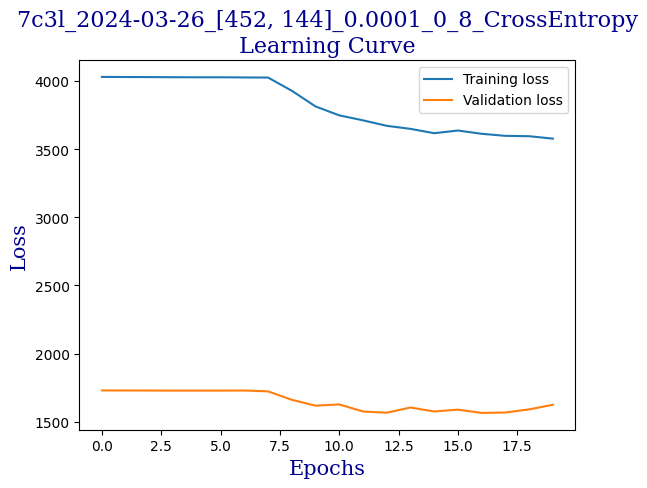

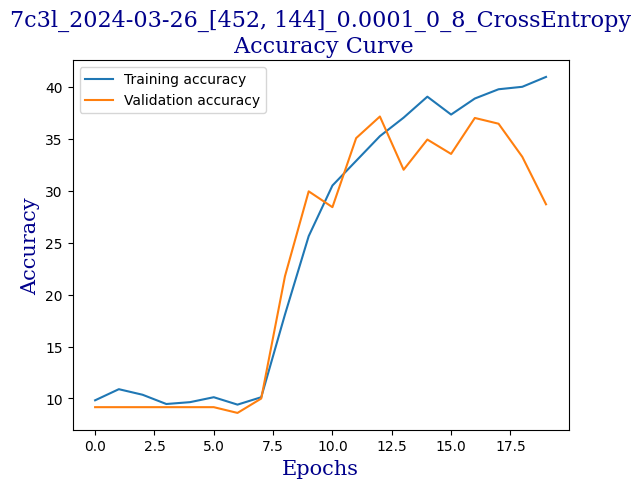

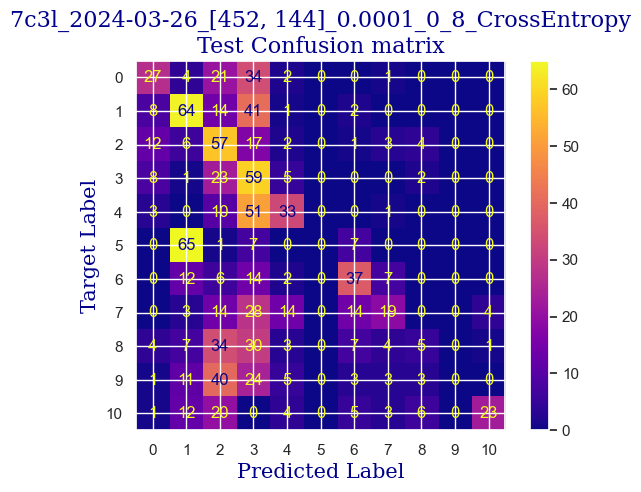

 
 END 7c3l [452, 144] Run Time:  5609.812825071
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
5622.254118315
5609.814729423
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.886377156454492
validating...


  5%|█████▌                                                                                                          | 1/20 [00:30<09:33, 30.18s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 10%|███████████▏                                                                                                    | 2/20 [01:00<09:03, 30.20s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:30<08:33, 30.22s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [02:01<08:04, 30.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:31<07:34, 30.32s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [03:01<07:05, 30.38s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:32<06:34, 30.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [04:02<06:04, 30.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:32<05:33, 30.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:03<05:03, 30.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:33<04:33, 30.40s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [06:01<03:57, 29.67s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:32<03:29, 29.88s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:02<03:00, 30.04s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:32<02:30, 30.10s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:02<02:00, 30.13s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:33<01:30, 30.18s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:03<01:00, 30.32s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:33<00:30, 30.25s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:04<00:00, 30.21s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  11.005353955978585
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


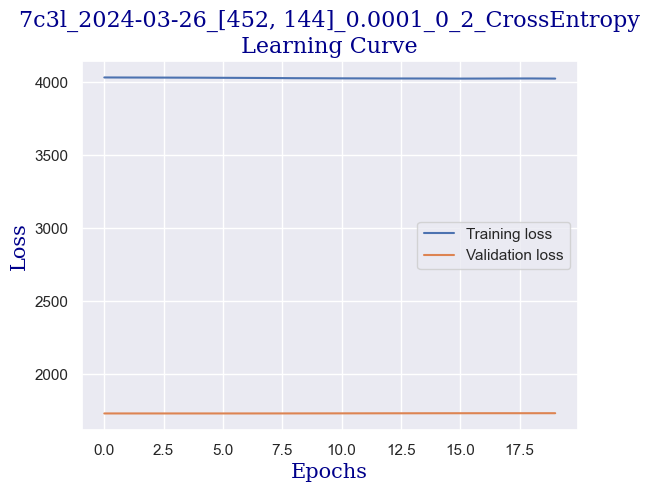

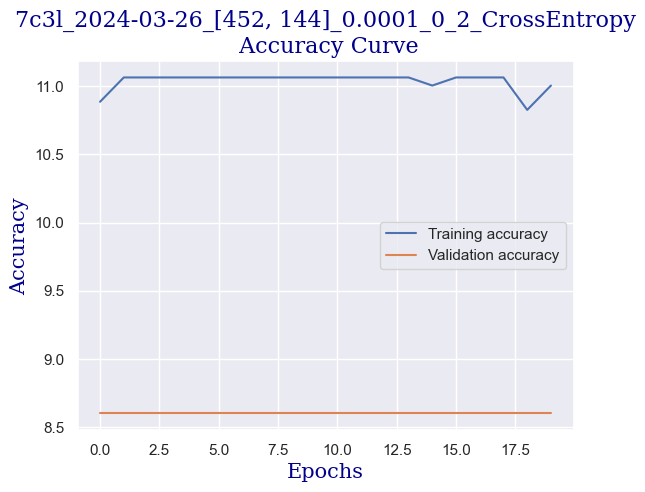

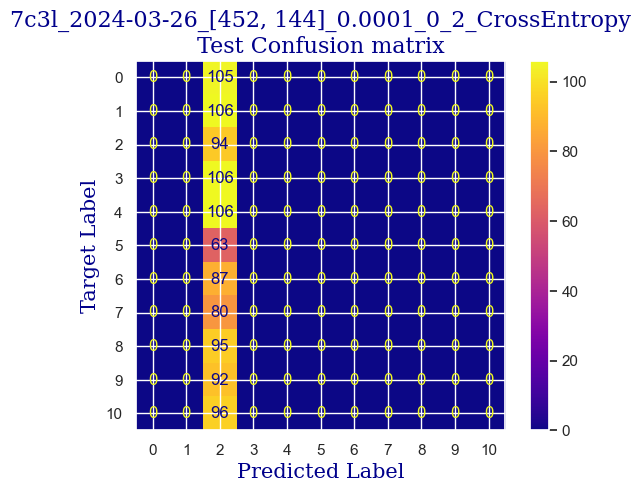

 
 END 7c3l [452, 144] Run Time:  5626.361113169
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
11248.616545259
11236.177139714
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  11.124330755502678
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:17, 29.34s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.707911957168353
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:48, 29.34s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.518143961927423
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:18, 29.31s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.458655562165378
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.24330755502677
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:19, 29.32s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.518143961927423
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:50, 29.35s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.053539559785841
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:22<06:10, 28.52s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  13.622843545508626
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:52<05:45, 28.82s/it]

validation accuracy:  21.7753120665742
Training...
train accuracy:  23.31945270672219
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:21<05:18, 28.96s/it]

validation accuracy:  22.88488210818308
Training...
train accuracy:  28.316478286734085
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:50<04:50, 29.04s/it]

validation accuracy:  27.323162274618586
Training...
train accuracy:  28.970850684116595
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:20<04:22, 29.17s/it]

validation accuracy:  28.01664355062413
Training...
train accuracy:  30.220107079119572
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:49<03:53, 29.23s/it]

validation accuracy:  27.184466019417474
Training...
train accuracy:  32.3022010707912
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:18<03:24, 29.24s/it]

validation accuracy:  27.739251040221912
Training...
train accuracy:  28.019036287923853
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:48<02:55, 29.30s/it]

validation accuracy:  28.29403606102635
Training...
train accuracy:  31.945270672218918
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:17<02:26, 29.28s/it]

validation accuracy:  27.045769764216367
Training...
train accuracy:  31.05294467578822
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:46<01:57, 29.32s/it]

validation accuracy:  26.352288488210817
Training...
train accuracy:  33.72992266508031
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:28, 29.36s/it]

validation accuracy:  26.629680998613036
Training...
train accuracy:  34.56276026174896
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:58, 29.41s/it]

validation accuracy:  29.542302357836338
Training...
train accuracy:  35.693039857227845
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:15<00:29, 29.44s/it]

validation accuracy:  29.819694868238557
Training...
train accuracy:  36.64485425342058
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:44<00:00, 29.25s/it]

validation accuracy:  28.71012482662968
Testing...


 
 train acc:  36.64485425342058
 
 val acc:  28.71012482662968
 
 test acc:  30.776699029126213


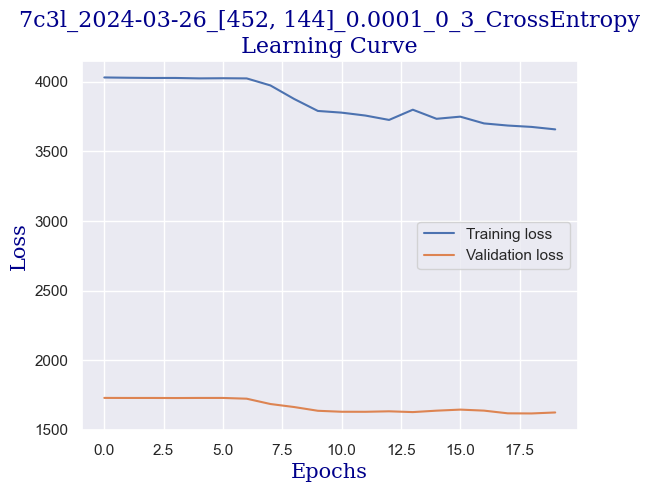

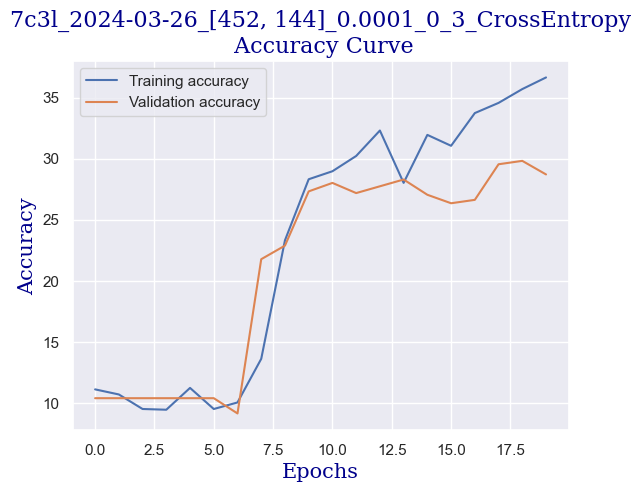

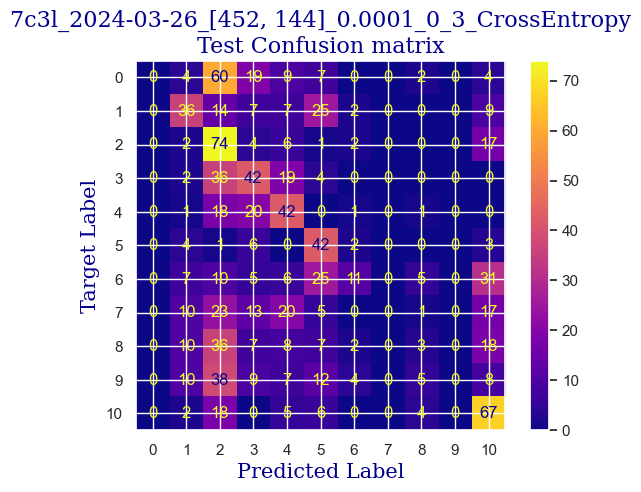

 
 END 7c3l [452, 144] Run Time:  5601.943677346
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
16850.561292654
16838.121887856
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.982748364069007
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:22, 29.63s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  8.863771564544914
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:57<08:33, 28.52s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.518143961927423
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:14, 29.08s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.934562760261748
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:51, 29.46s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  8.625817965496728
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:22, 29.50s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.994051160023796
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:54, 29.61s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.994051160023796
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:26<06:26, 29.74s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  8.982748364069007
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:56<05:57, 29.75s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  11.06484235574063
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:26<05:27, 29.76s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.994051160023796
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:56<04:58, 29.82s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.053539559785841
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:25<04:28, 29.80s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.161213563355146
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:55<03:58, 29.81s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.875074360499703
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:25<03:28, 29.81s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.57763236168947
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:55<02:58, 29.83s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.57763236168947
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:24<02:28, 29.75s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:55<01:59, 29.91s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.39916716240333
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:25<01:29, 29.91s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.053539559785841
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:52<00:58, 29.18s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.220701963117191
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:22<00:29, 29.39s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.220701963117191
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:52<00:00, 29.62s/it]

validation accuracy:  9.153952843273231
Testing...


 
 train acc:  9.220701963117191
 
 val acc:  9.153952843273231
 
 test acc:  9.902912621359224


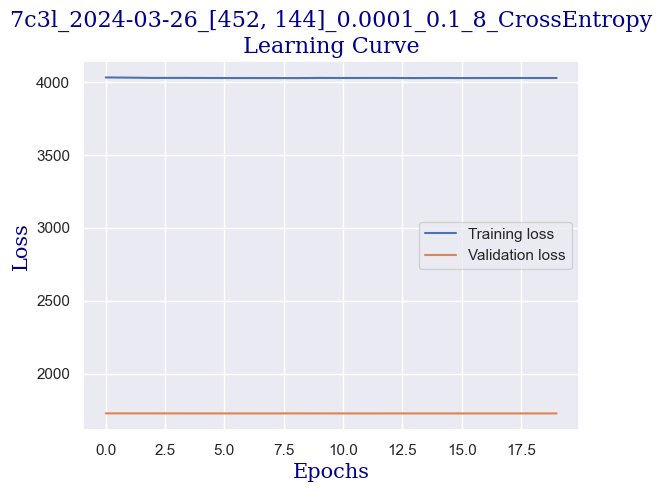

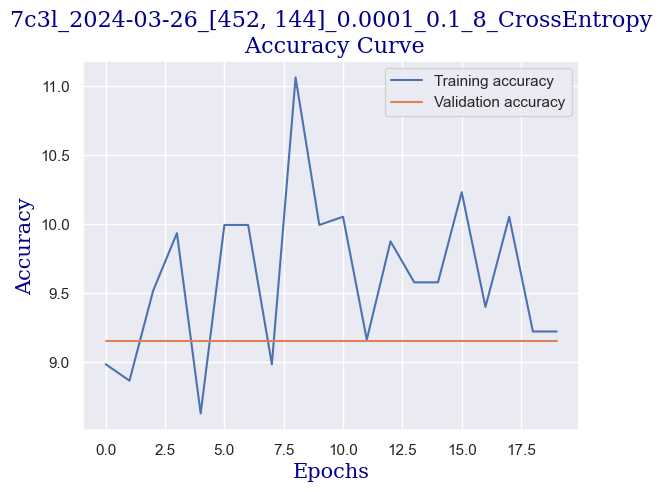

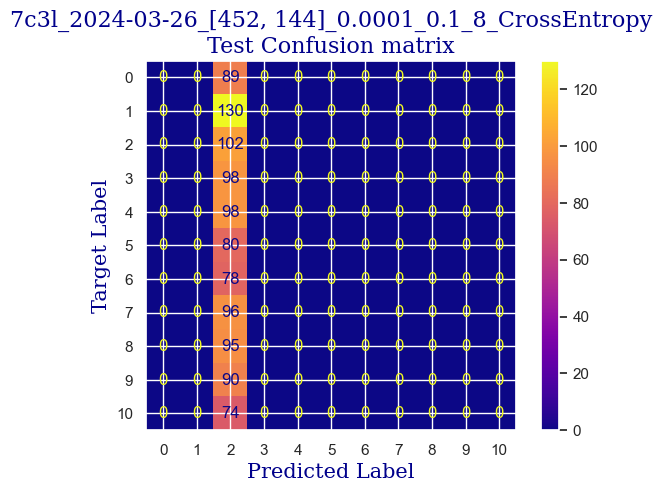

 
 END 7c3l [452, 144] Run Time:  5619.090481439998
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
22469.652649186
22457.213241360998
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.506841165972636
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:18, 29.42s/it]

validation accuracy:  9.847434119278779
Training...
train accuracy:  9.39916716240333
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:48, 29.39s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.362284354550862
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:19, 29.39s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.886377156454492
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:20, 29.35s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.838191552647235
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:50, 29.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.945865556216537
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:25<06:21, 29.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:54<05:50, 29.25s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.469958358120167
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:23<05:22, 29.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.350981558596075
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:53<04:53, 29.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.41046995835812
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:22<04:24, 29.35s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.945865556216537
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:52<03:54, 29.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.886377156454492
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:19<03:21, 28.79s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.934562760261748
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:49<02:55, 29.21s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.75609756097561
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:19<02:27, 29.46s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.469958358120167
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:49<01:58, 29.55s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:19<01:28, 29.66s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.362284354550862
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:49<00:59, 29.71s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.875074360499703
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:19<00:29, 29.74s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.350981558596075
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:49<00:00, 29.45s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  10.350981558596075
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


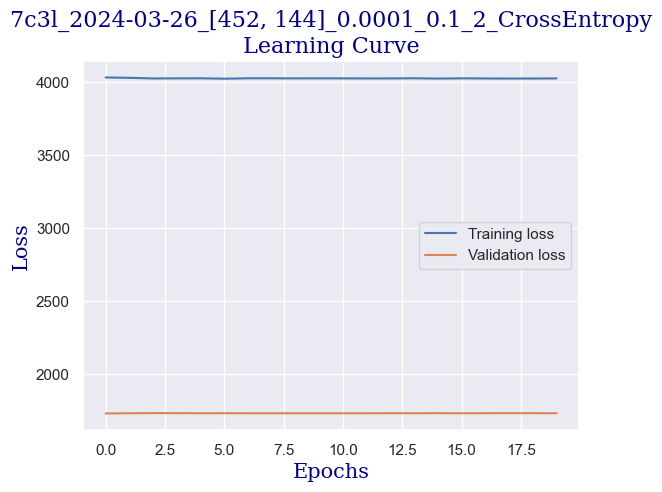

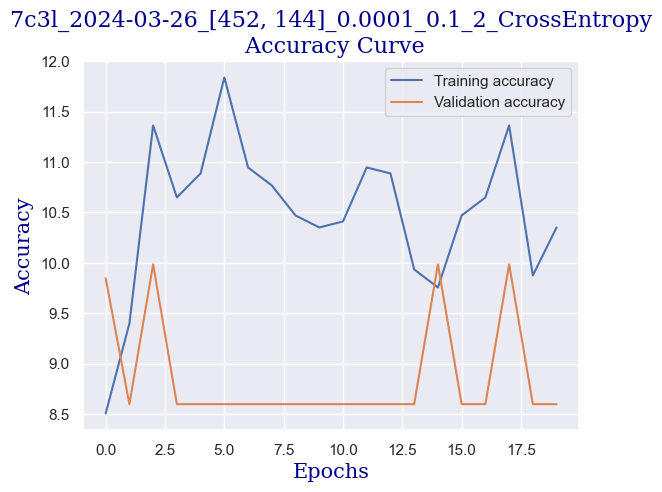

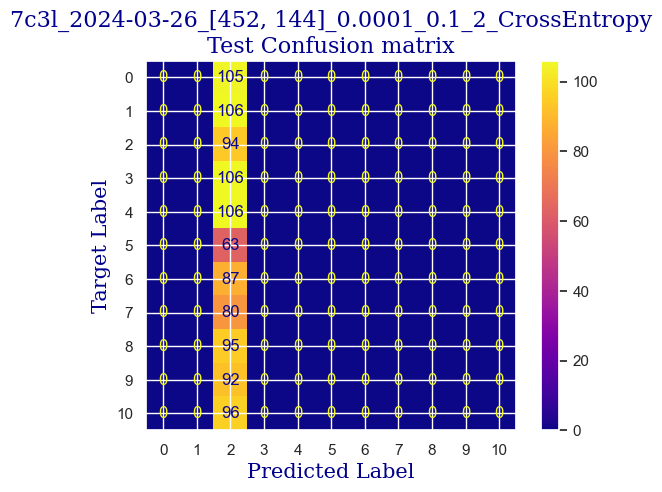

 
 END 7c3l [452, 144] Run Time:  5609.237785778001
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
28078.891655248
28066.452250858998
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.707911957168353
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:17, 29.34s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.350981558596075
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:46, 29.26s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.57763236168947
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:18, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.637120761451518
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.35s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.053539559785841
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:20, 29.34s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:55<06:50, 29.30s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.469958358120167
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:25<06:21, 29.36s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  11.06484235574063
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:54<05:50, 29.25s/it]

validation accuracy:  13.592233009708737
Training...
train accuracy:  15.70493753718025
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:21<05:15, 28.69s/it]

validation accuracy:  17.337031900138697
Training...
train accuracy:  22.843545508625816
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:51<04:48, 28.85s/it]

validation accuracy:  20.249653259361995
Training...
train accuracy:  25.580011897679956
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:20<04:21, 29.05s/it]

validation accuracy:  22.88488210818308
Training...
train accuracy:  30.517549077929807
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:49<03:53, 29.14s/it]

validation accuracy:  25.79750346740638
Training...
train accuracy:  33.432480666270074
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:19<03:24, 29.20s/it]

validation accuracy:  26.21359223300971
Training...
train accuracy:  34.62224866151101
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:48<02:55, 29.19s/it]

validation accuracy:  29.403606102635226
Training...
train accuracy:  37.001784651992864
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:17<02:26, 29.24s/it]

validation accuracy:  33.14840499306519
Training...
train accuracy:  37.65615704937537
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:47<01:57, 29.28s/it]

validation accuracy:  32.45492371705964
Training...
train accuracy:  37.418203450327184
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:27, 29.31s/it]

validation accuracy:  34.95145631067961
Training...
train accuracy:  40.86853063652588
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:58, 29.34s/it]

validation accuracy:  33.00970873786408
Training...
train accuracy:  44.55681142177275
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:15<00:29, 29.38s/it]

validation accuracy:  36.33841886269071
Training...
train accuracy:  44.37834622248661
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:44<00:00, 29.24s/it]

validation accuracy:  34.535367545076284
Testing...


 
 train acc:  44.37834622248661
 
 val acc:  34.535367545076284
 
 test acc:  35.92233009708738


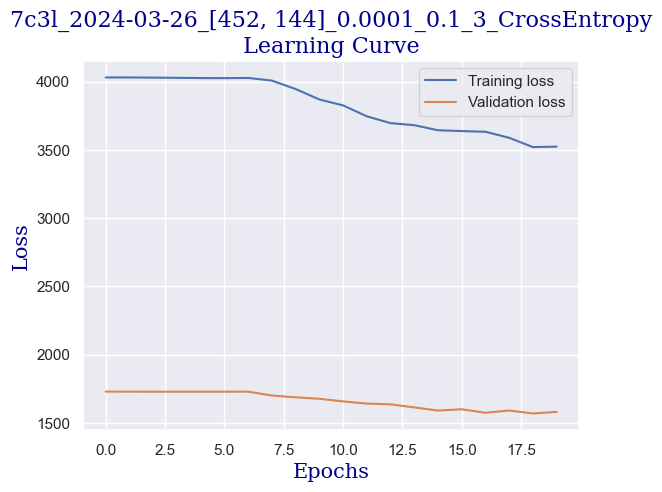

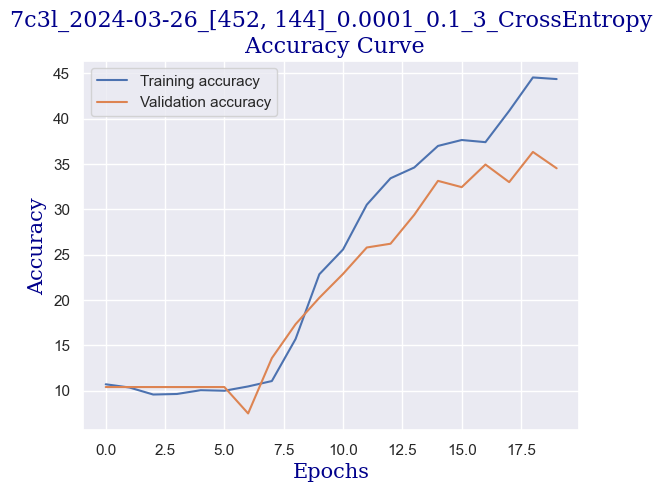

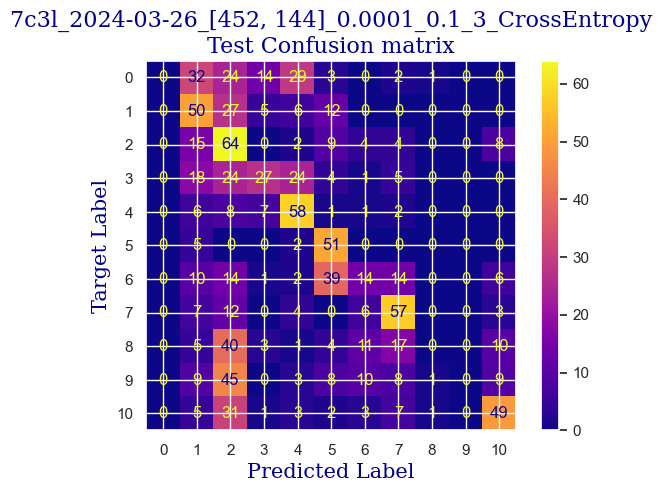

 
 END 7c3l [452, 144] Run Time:  5608.441808167001
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
33687.334744158
33674.895341297
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.685306365258775
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:16, 29.31s/it]

validation accuracy:  9.57004160887656
Training...
train accuracy:  9.1017251635931
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:44, 29.14s/it]

validation accuracy:  9.57004160887656
Training...
train accuracy:  10.291493158834028
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:16, 29.21s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.934562760261748
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:54<07:33, 28.35s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.75609756097561
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:24<07:10, 28.73s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.934562760261748
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:53<06:43, 28.86s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:22<06:16, 28.95s/it]

validation accuracy:  13.0374479889043
Training...
train accuracy:  17.608566329565733
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:51<05:48, 29.07s/it]

validation accuracy:  20.665742024965326
Training...
train accuracy:  22.248661511005356
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:20<05:20, 29.10s/it]

validation accuracy:  22.330097087378643
Training...
train accuracy:  25.342058298631763
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:50<04:52, 29.22s/it]

validation accuracy:  23.855755894590846
Training...
train accuracy:  27.245687091017253
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:19<04:22, 29.22s/it]

validation accuracy:  22.607489597780862
Training...
train accuracy:  30.57703747769185
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:48<03:53, 29.22s/it]

validation accuracy:  27.877947295423024
Training...
train accuracy:  29.44675788221297
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:17<03:24, 29.23s/it]

validation accuracy:  28.29403606102635
Training...
train accuracy:  32.83759666864962
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:47<02:55, 29.30s/it]

validation accuracy:  28.01664355062413
Training...
train accuracy:  36.04997025580012
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:16<02:26, 29.23s/it]

validation accuracy:  29.958391123439664
Training...
train accuracy:  38.429506246281974
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:45<01:56, 29.23s/it]

validation accuracy:  34.11927877947296
Training...
train accuracy:  41.4039262343843
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:15<01:27, 29.27s/it]

validation accuracy:  28.155339805825243
Training...
train accuracy:  40.92801903628792
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:44<00:58, 29.21s/it]

validation accuracy:  36.1997226074896
Training...
train accuracy:  44.080904223676384
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:13<00:29, 29.18s/it]

validation accuracy:  34.535367545076284
Training...
train accuracy:  46.400951814396194
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:41<00:00, 29.05s/it]

validation accuracy:  37.586685159500696
Testing...


 
 train acc:  46.400951814396194
 
 val acc:  37.586685159500696
 
 test acc:  34.85436893203884


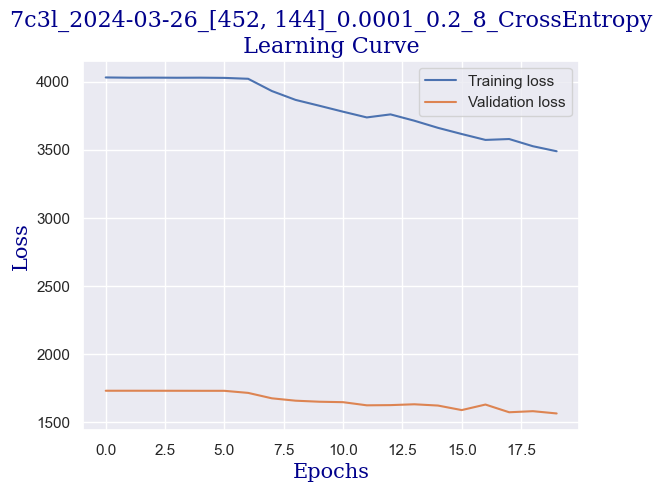

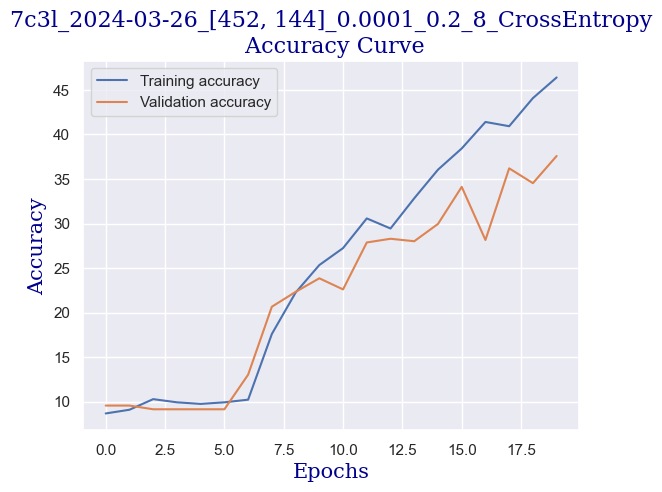

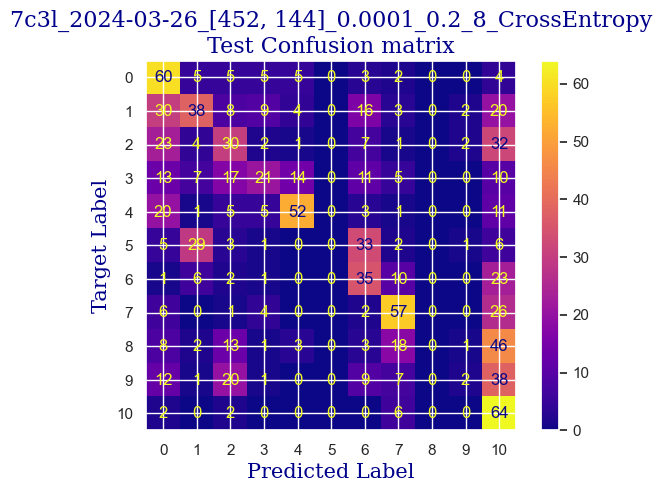

 
 END 7c3l [452, 144] Run Time:  5585.506977246005
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
39272.842676984
39260.403271555
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  11.06484235574063
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:22, 29.58s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 10%|███████████▏                                                                                                    | 2/20 [01:00<09:01, 30.11s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:30<08:36, 30.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [02:00<08:04, 30.29s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:31<07:34, 30.30s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [03:01<07:05, 30.40s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:32<06:34, 30.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [04:02<06:04, 30.41s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:32<05:34, 30.40s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:03<05:03, 30.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:33<04:33, 30.35s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [06:03<04:02, 30.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:34<03:32, 30.31s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:04<03:02, 30.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.183819155264723
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:32<02:28, 29.62s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:02<01:59, 29.84s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.707911957168353
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:32<01:29, 29.93s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:03<01:00, 30.02s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:33<00:30, 30.12s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.183819155264723
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:03<00:00, 30.19s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  11.183819155264723
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


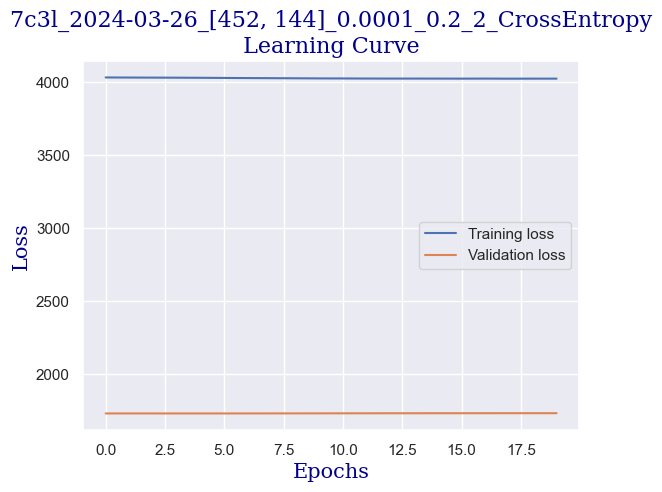

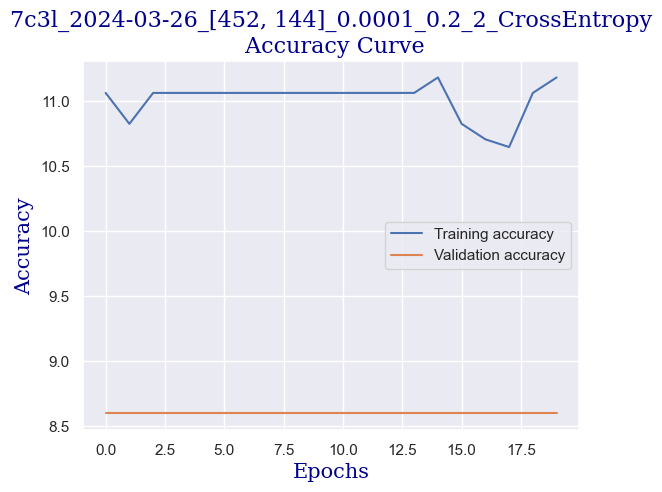

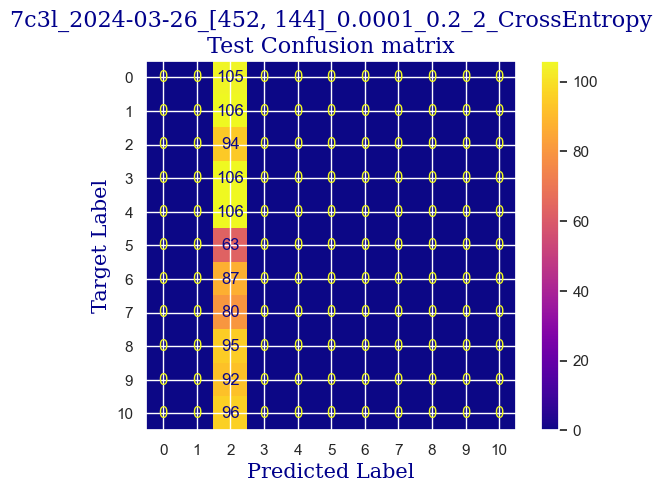

 
 END 7c3l [452, 144] Run Time:  5628.644606731999
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  0.0001   idx: 0 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
44901.488146237
44889.048741613995
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.161213563355146
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:20, 29.50s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.934562760261748
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:49, 29.43s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.875074360499703
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:19, 29.38s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.41046995835812
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.36s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.75609756097561
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:20, 29.38s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.875074360499703
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:52, 29.50s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.945865556216537
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:26<06:24, 29.55s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.24330755502677
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:55<05:54, 29.57s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.815585960737657
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:25<05:26, 29.72s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.75609756097561
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:53<04:50, 29.04s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:23<04:24, 29.35s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.648423557406305
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:53<03:55, 29.50s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.529446757882214
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:23<03:27, 29.58s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.886377156454492
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:52<02:57, 29.66s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:22<02:28, 29.75s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.469958358120167
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:52<01:59, 29.77s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.172516359309935
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:22<01:29, 29.80s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:52<00:59, 29.88s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.815585960737657
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:22<00:29, 29.83s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.815585960737657
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:52<00:00, 29.62s/it]

validation accuracy:  10.402219140083217
Testing...


 
 train acc:  9.815585960737657
 
 val acc:  10.402219140083217
 
 test acc:  8.058252427184467


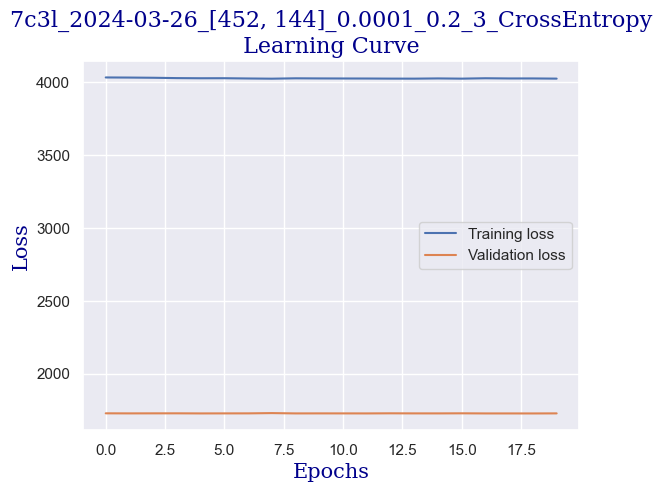

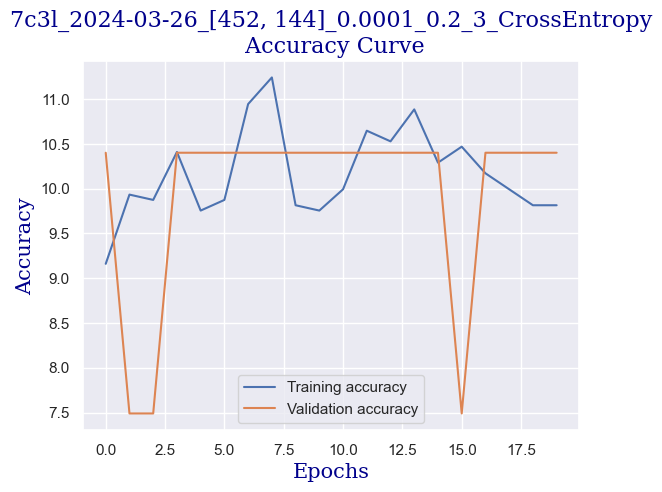

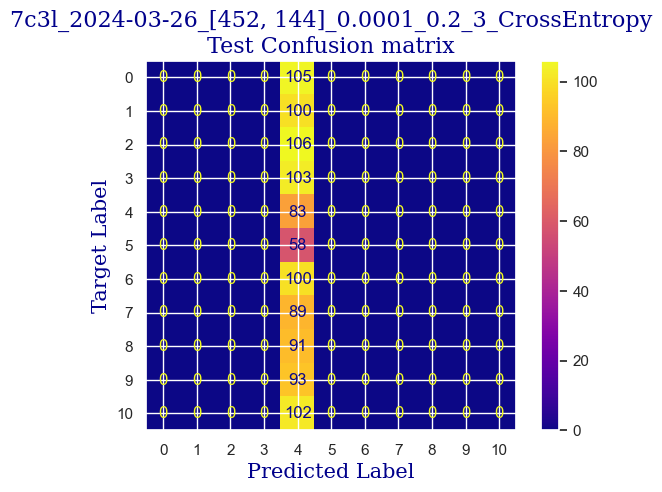

 
 END 7c3l [452, 144] Run Time:  5611.543546859
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
50513.034525752
50500.595221097
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.291493158834028
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:19, 29.43s/it]

validation accuracy:  8.876560332871012
Training...
train accuracy:  9.1017251635931
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:48, 29.38s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.41046995835812
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:18, 29.32s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.707911957168353
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.32s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.875074360499703
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:24<07:07, 28.48s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.39916716240333
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:53<06:43, 28.79s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.113027959547887
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:22<06:16, 28.93s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.696609161213564
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:52<05:50, 29.19s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.934562760261748
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:22<05:23, 29.37s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.113027959547887
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:52<04:55, 29.53s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.41046995835812
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:22<04:27, 29.67s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.280190362879239
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:51<03:57, 29.67s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.291493158834028
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:21<03:28, 29.72s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.41046995835812
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:51<02:57, 29.66s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.767400356930398
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:21<02:28, 29.71s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.469958358120167
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:51<01:59, 29.78s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:20<01:29, 29.77s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:50<00:59, 29.84s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.637120761451518
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:20<00:29, 29.80s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.469958358120167
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:50<00:00, 29.52s/it]

validation accuracy:  9.153952843273231
Testing...


 
 train acc:  10.469958358120167
 
 val acc:  9.153952843273231
 
 test acc:  9.902912621359224


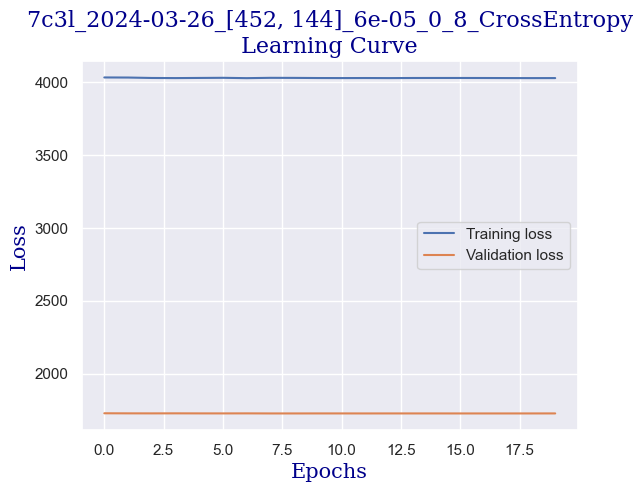

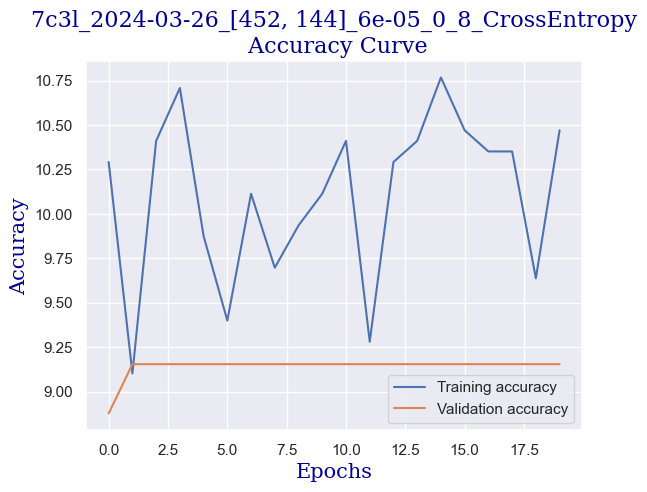

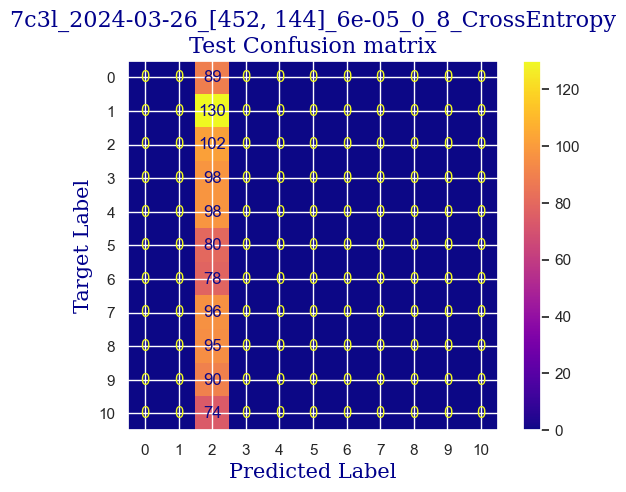

 
 END 7c3l [452, 144] Run Time:  5597.279362344998
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
56110.314800585
56097.875392459
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.280190362879239
validating...


  5%|█████▌                                                                                                          | 1/20 [00:28<08:53, 28.06s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.994051160023796
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:57<08:37, 28.77s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:26<08:13, 29.02s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.994051160023796
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:56<07:49, 29.35s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.529446757882214
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:25<07:19, 29.30s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.183819155264723
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:55<06:50, 29.32s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.600237953599049
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:24<06:21, 29.34s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.362284354550862
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:53<05:52, 29.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.994051160023796
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:22<05:22, 29.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:52<04:53, 29.31s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.58893515764426
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:21<04:24, 29.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.957168352171326
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:51<03:55, 29.39s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.350981558596075
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:20<03:26, 29.45s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.350981558596075
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:50<02:56, 29.48s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  12.135633551457465
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:19<02:26, 29.40s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:48<01:57, 29.32s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.172516359309935
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:15<01:26, 28.68s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.41046995835812
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:57, 28.82s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.23200475907198
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:14<00:28, 28.93s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.458655562165378
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:43<00:00, 29.19s/it]

validation accuracy:  9.986130374479888
Testing...


 
 train acc:  9.458655562165378
 
 val acc:  9.986130374479888
 
 test acc:  10.29126213592233


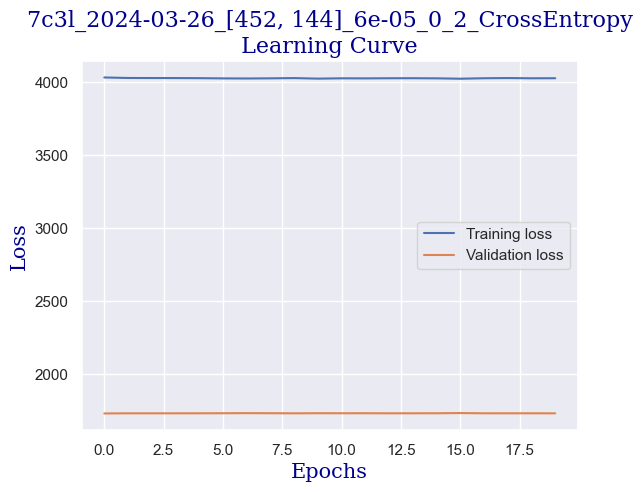

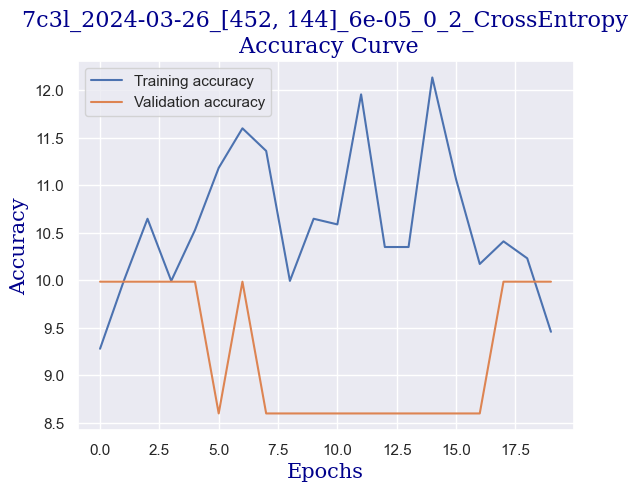

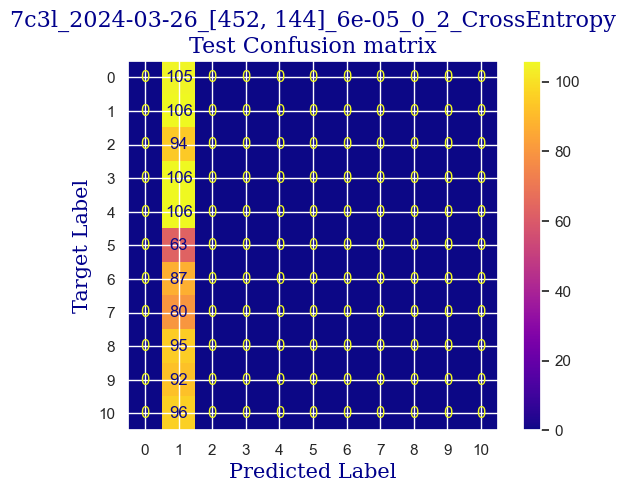

 
 END 7c3l [452, 144] Run Time:  5607.169973871001
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
61717.485894056
61705.046491718
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.58893515764426
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:21, 29.55s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:59<08:50, 29.49s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.23200475907198
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:20, 29.45s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.41046995835812
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:51, 29.44s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.648423557406305
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:27<07:22, 29.48s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.469958358120167
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:52, 29.49s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.469958358120167
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:27<06:26, 29.73s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.529446757882214
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:57<05:57, 29.79s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.469958358120167
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:27<05:28, 29.85s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.648423557406305
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:56<04:58, 29.88s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.280190362879239
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:27<04:29, 29.94s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.302795954788817
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:54<03:53, 29.19s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.005353955978585
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:24<03:25, 29.35s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.58893515764426
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:53<02:56, 29.47s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.06484235574063
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:24<02:28, 29.70s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.58893515764426
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:54<01:59, 29.75s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.053539559785841
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:23<01:29, 29.79s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.458655562165378
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:53<00:59, 29.76s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.518143961927423
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:23<00:29, 29.84s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:53<00:00, 29.68s/it]

validation accuracy:  10.402219140083217
Testing...


 
 train acc:  9.994051160023796
 
 val acc:  10.402219140083217
 
 test acc:  8.058252427184467


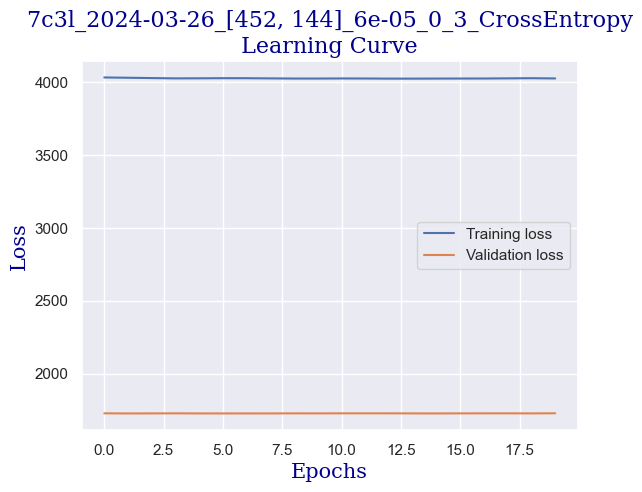

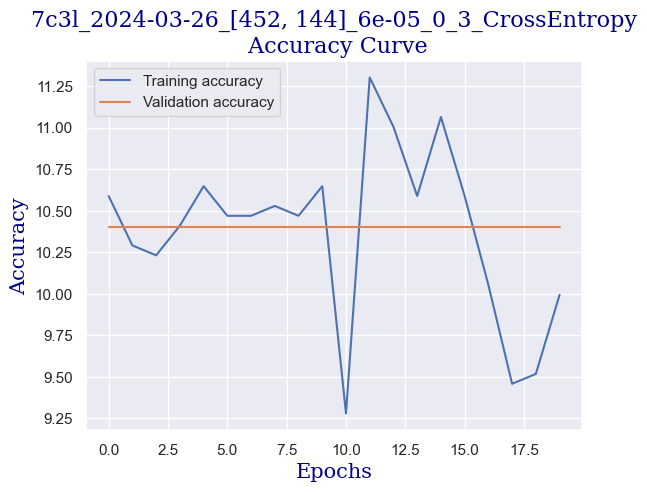

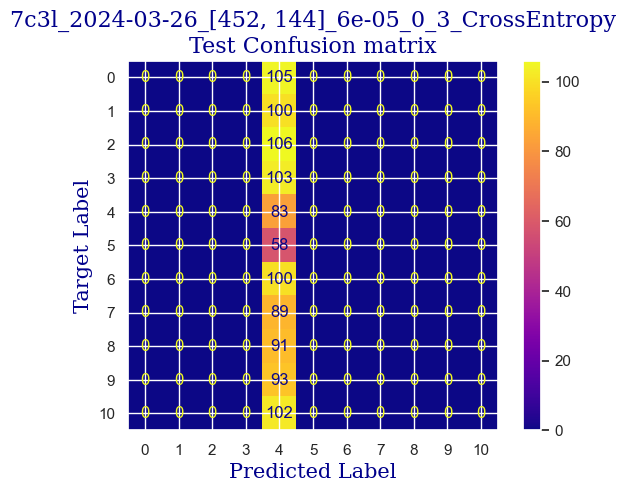

 
 END 7c3l [452, 144] Run Time:  5633.791491158998
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
67351.278520473
67338.839116578
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.637120761451518
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:17, 29.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.339678762641284
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:46, 29.24s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.469958358120167
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:19, 29.40s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:50, 29.43s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.280190362879239
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:27<07:22, 29.47s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.815585960737657
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:51, 29.38s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  11.06484235574063
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:23<06:12, 28.69s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.696609161213564
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:52<05:46, 28.87s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  8.74479476502082
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:22<05:19, 29.04s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  18.79833432480666
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:51<04:50, 29.09s/it]

validation accuracy:  26.352288488210817
Training...
train accuracy:  30.220107079119572
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:20<04:21, 29.09s/it]

validation accuracy:  33.14840499306519
Training...
train accuracy:  34.7412254610351
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:49<03:53, 29.13s/it]

validation accuracy:  35.64493758668516
Training...
train accuracy:  36.2879238548483
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:19<03:24, 29.17s/it]

validation accuracy:  34.25797503467407
Training...
train accuracy:  38.37001784651993
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:48<02:55, 29.23s/it]

validation accuracy:  40.77669902912621
Training...
train accuracy:  42.23676383105294
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:17<02:26, 29.23s/it]

validation accuracy:  39.66712898751734
Training...
train accuracy:  40.749553837001784
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:47<01:57, 29.28s/it]

validation accuracy:  38.97364771151179
Training...
train accuracy:  41.04699583581202
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:27, 29.30s/it]

validation accuracy:  42.44105409153953
Training...
train accuracy:  44.43783462224866
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:58, 29.33s/it]

validation accuracy:  43.689320388349515
Training...
train accuracy:  46.46044021415824
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:15<00:29, 29.34s/it]

validation accuracy:  43.828016643550626
Training...
train accuracy:  46.2819750148721
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:44<00:00, 29.22s/it]

validation accuracy:  41.47018030513176
Testing...


 
 train acc:  46.2819750148721
 
 val acc:  41.47018030513176
 
 test acc:  35.33980582524272


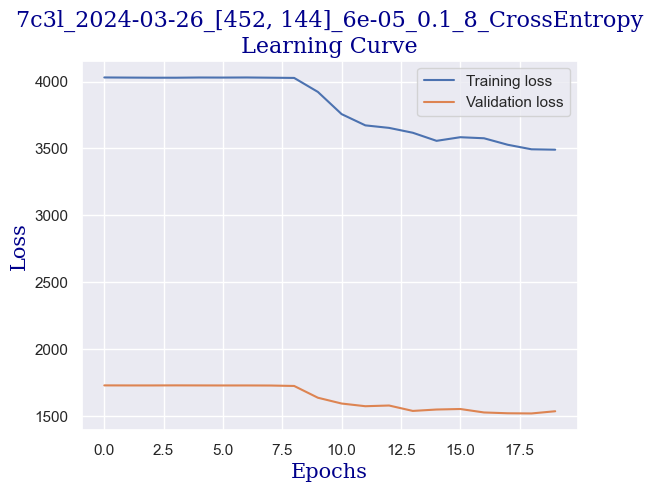

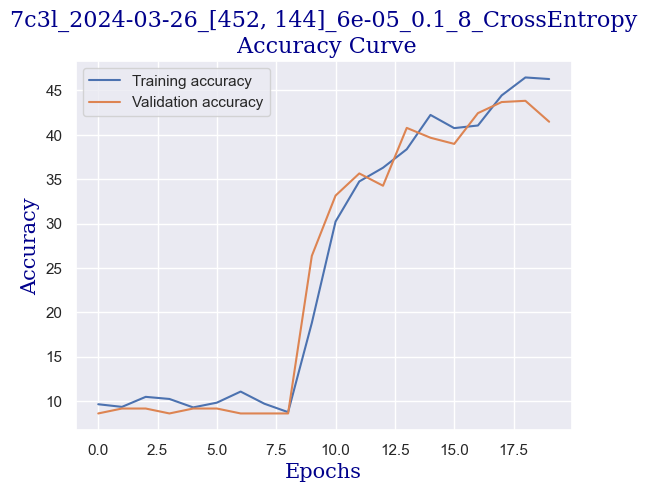

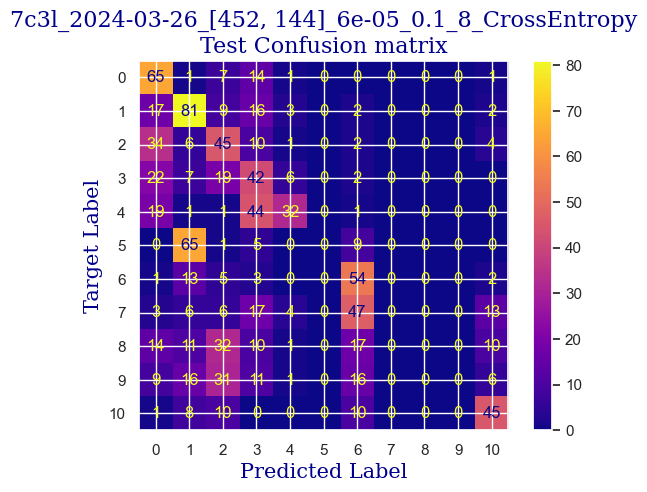

 
 END 7c3l [452, 144] Run Time:  5612.542414757001
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
72963.822297979
72951.382893646
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  10.826888756692444
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:27, 29.89s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 10%|███████████▏                                                                                                    | 2/20 [01:00<09:01, 30.08s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:13, 29.00s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:50, 29.44s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:28<07:27, 29.85s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:59<07:01, 30.10s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:29<06:31, 30.13s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:59<06:02, 30.22s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:30<05:33, 30.30s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:00<05:03, 30.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:30<04:33, 30.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [06:01<04:02, 30.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:31<03:33, 30.43s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:02<03:02, 30.41s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:32<02:31, 30.38s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:02<02:01, 30.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:33<01:31, 30.38s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.183819155264723
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:01<00:59, 29.59s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:31<00:29, 29.74s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:01<00:00, 30.07s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  11.005353955978585
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


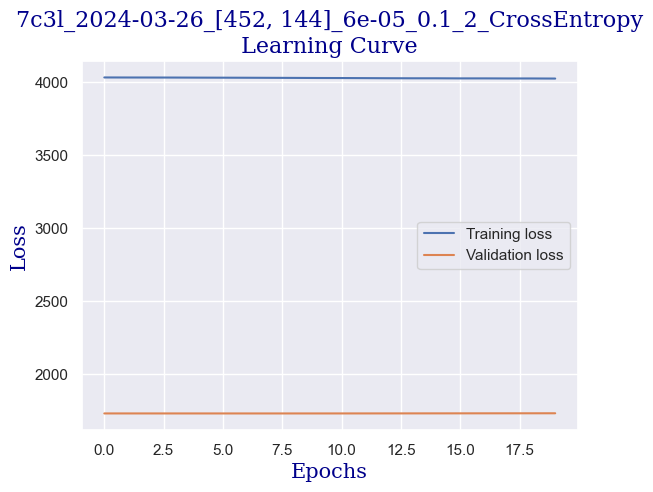

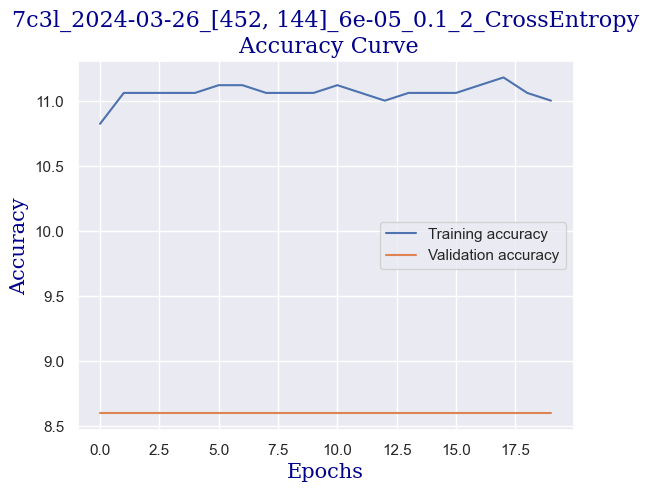

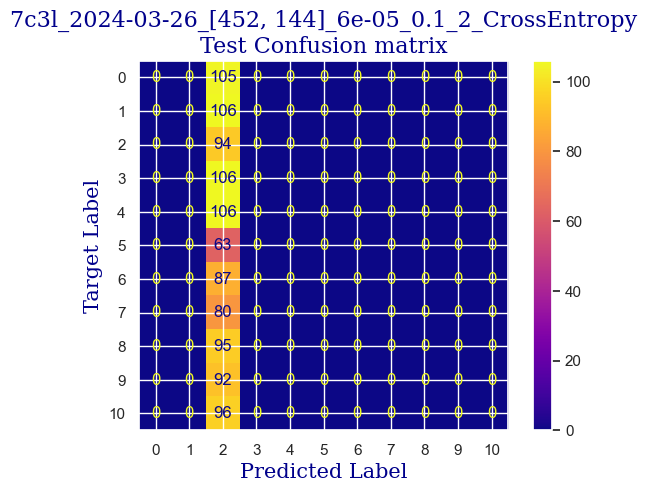

 
 END 7c3l [452, 144] Run Time:  5613.338929502002
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
78577.162130793
78564.722727844
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.39916716240333
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:21, 29.54s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.58893515764426
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:47, 29.33s/it]

validation accuracy:  9.57004160887656
Training...
train accuracy:  10.350981558596075
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:18, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.421772754312908
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:47, 29.20s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.458655562165378
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:18, 29.22s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.41046995835812
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:55<06:49, 29.27s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.23200475907198
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:25<06:20, 29.29s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.350981558596075
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:54<05:50, 29.24s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.696609161213564
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:23<05:21, 29.26s/it]

validation accuracy:  11.373092926490985
Training...
train accuracy:  12.07614515169542
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:53<04:53, 29.36s/it]

validation accuracy:  11.650485436893204
Training...
train accuracy:  19.928613920285546
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:22<04:23, 29.33s/it]

validation accuracy:  24.133148404993065
Training...
train accuracy:  24.806662700773348
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:51<03:54, 29.28s/it]

validation accuracy:  24.826629680998614
Training...
train accuracy:  26.29387269482451
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:18<03:20, 28.60s/it]

validation accuracy:  28.43273231622746
Training...
train accuracy:  29.268292682926827
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:47<02:53, 28.85s/it]

validation accuracy:  26.352288488210817
Training...
train accuracy:  29.803688280785245
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:17<02:25, 29.09s/it]

validation accuracy:  27.600554785020805
Training...
train accuracy:  32.36168947055324
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:47<01:56, 29.22s/it]

validation accuracy:  26.21359223300971
Training...
train accuracy:  32.65913146936347
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:27, 29.20s/it]

validation accuracy:  29.26490984743412
Training...
train accuracy:  32.480666270077336
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:58, 29.24s/it]

validation accuracy:  28.01664355062413
Training...
train accuracy:  35.574063057703746
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:14<00:29, 29.29s/it]

validation accuracy:  30.651872399445214
Training...
train accuracy:  35.098155859607374
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:44<00:00, 29.21s/it]

validation accuracy:  31.345353675450767
Testing...


 
 train acc:  35.098155859607374
 
 val acc:  31.345353675450767
 
 test acc:  29.80582524271845


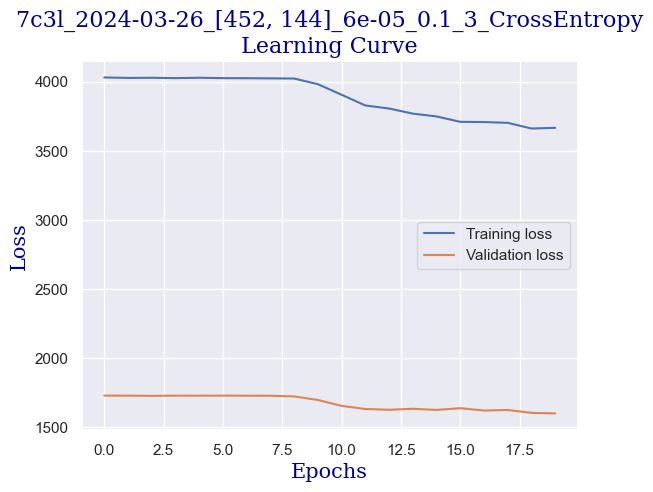

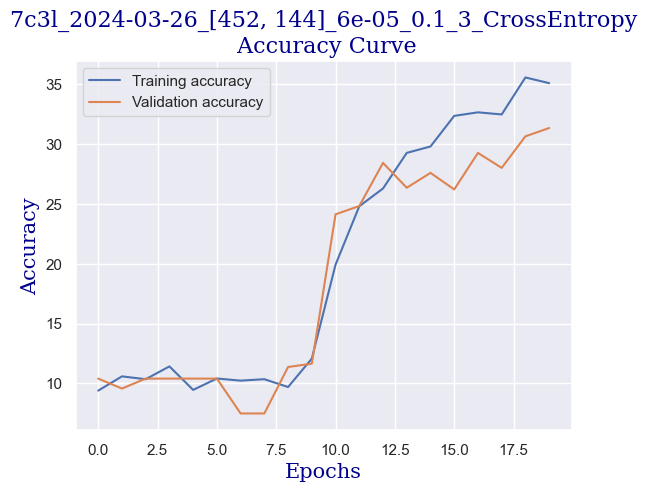

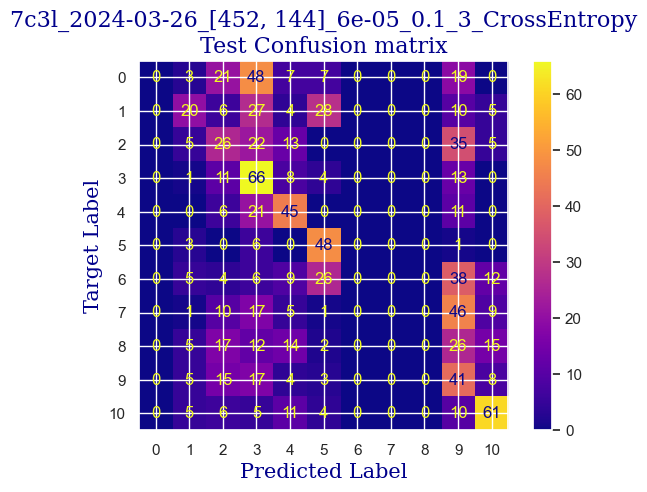

 
 END 7c3l [452, 144] Run Time:  5611.488254819997
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
84188.651767731
84176.212365127
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.74479476502082
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:22, 29.58s/it]

validation accuracy:  9.70873786407767
Training...
train accuracy:  9.815585960737657
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:49, 29.43s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  8.804283164782866
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:19, 29.40s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.458655562165378
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:50, 29.38s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  8.804283164782866
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:27<07:20, 29.40s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.172516359309935
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:52, 29.48s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  8.74479476502082
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:26<06:23, 29.47s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.815585960737657
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:55<05:54, 29.53s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.518143961927423
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:23<05:16, 28.80s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.291493158834028
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:52<04:50, 29.01s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.875074360499703
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:21<04:22, 29.12s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.75609756097561
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:51<03:53, 29.18s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.934562760261748
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:20<03:24, 29.26s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.053539559785841
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:49<02:55, 29.22s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:18<02:26, 29.21s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.220701963117191
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:48<01:57, 29.27s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.57763236168947
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:18<01:28, 29.41s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  11.540749553837001
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:47<00:58, 29.27s/it]

validation accuracy:  19.55617198335645
Training...
train accuracy:  20.226055919095774
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:16<00:29, 29.26s/it]

validation accuracy:  31.484049930651874
Training...
train accuracy:  29.92266508030934
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:45<00:00, 29.28s/it]

validation accuracy:  31.622746185852986
Testing...


 
 train acc:  29.92266508030934
 
 val acc:  31.622746185852986
 
 test acc:  29.02912621359223


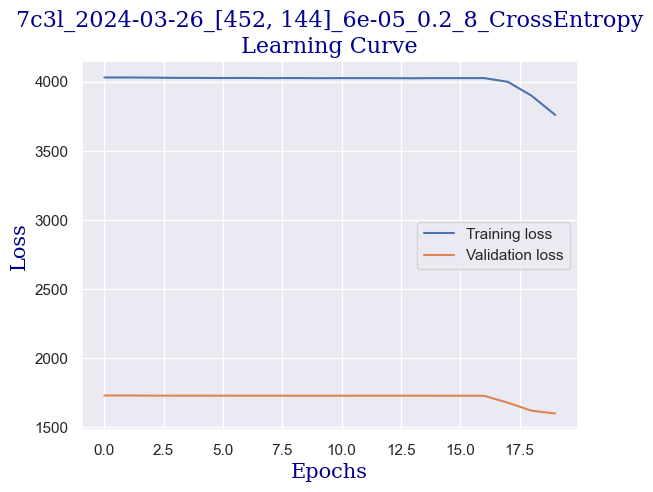

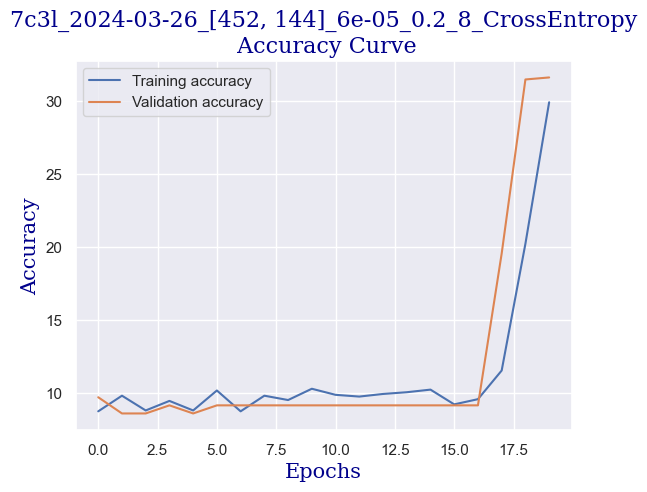

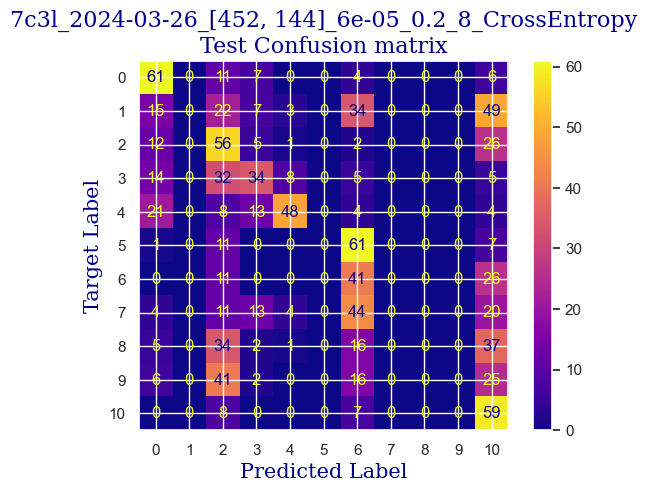

 
 END 7c3l [452, 144] Run Time:  5634.743313744999
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
89823.398172861
89810.958868601
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.042236763831053
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:25, 29.78s/it]

validation accuracy:  8.876560332871012
Training...
train accuracy:  9.75609756097561
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:59<08:52, 29.61s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.41046995835812
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:20, 29.43s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:55<07:38, 28.63s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.707911957168353
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:25<07:14, 28.99s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  9.75609756097561
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:54<06:47, 29.10s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.23200475907198
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:24<06:19, 29.19s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.529446757882214
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:53<05:50, 29.19s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.23200475907198
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:22<05:21, 29.26s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.350981558596075
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:52<04:53, 29.38s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.24330755502677
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:21<04:24, 29.41s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.172516359309935
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:51<03:56, 29.61s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.23200475907198
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:21<03:27, 29.70s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.58893515764426
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:51<02:58, 29.77s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:21<02:28, 29.72s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.826888756692444
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:51<01:59, 29.77s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.696609161213564
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:21<01:29, 29.82s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.469958358120167
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:51<00:59, 29.82s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.886377156454492
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:21<00:29, 29.88s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.767400356930398
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:48<00:00, 29.43s/it]

validation accuracy:  9.986130374479888
Testing...


 
 train acc:  10.767400356930398
 
 val acc:  9.986130374479888
 
 test acc:  10.29126213592233


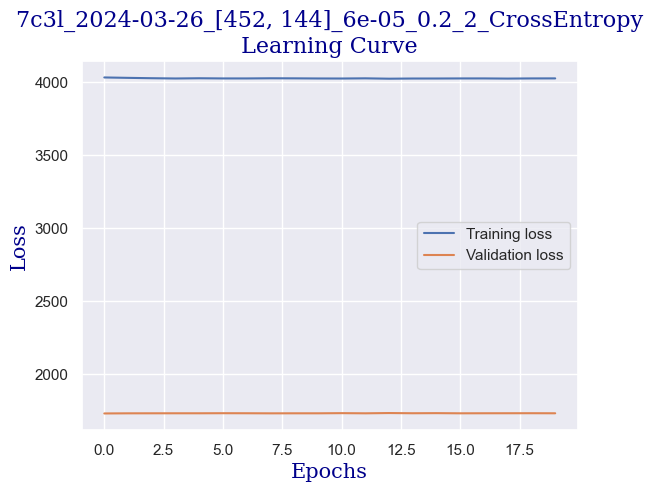

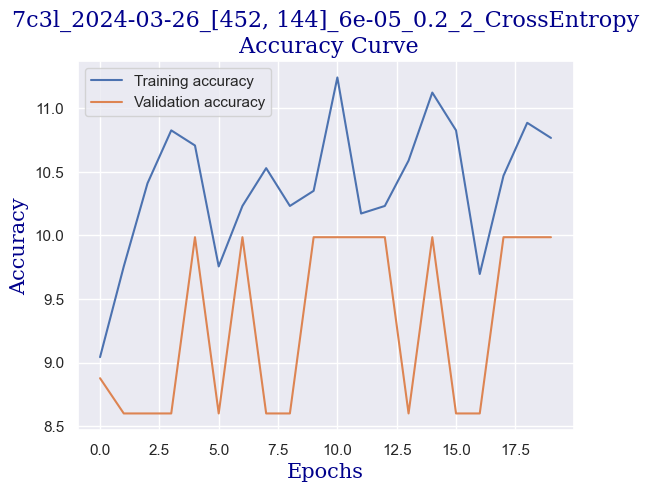

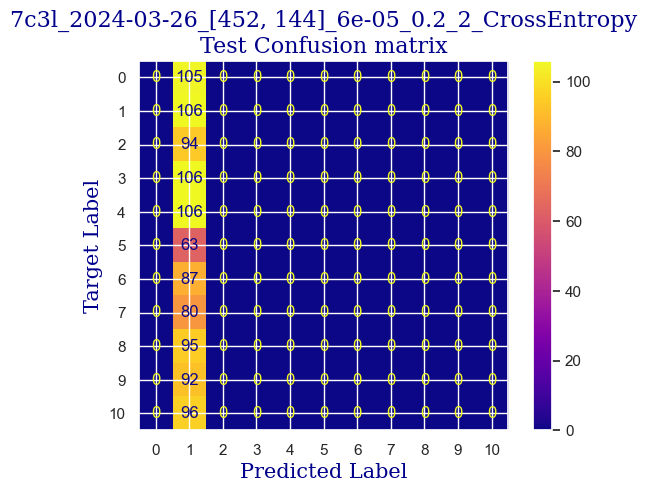

 
 END 7c3l [452, 144] Run Time:  5626.849221165001
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  6e-05   idx: 1 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
95450.24862368
95437.809219799
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.1017251635931
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:19, 29.47s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.124330755502678
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:48, 29.38s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.529446757882214
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:18, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.75609756097561
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.41046995835812
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:19, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.75609756097561
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:51, 29.38s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.529446757882214
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:25<06:21, 29.35s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.469958358120167
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:54<05:51, 29.26s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.57763236168947
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:23<05:22, 29.29s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.518143961927423
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:53<04:53, 29.33s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:22<04:24, 29.39s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.23200475907198
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:52<03:54, 29.37s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.41046995835812
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:21<03:25, 29.37s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.994051160023796
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:50<02:56, 29.38s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.350981558596075
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:20<02:26, 29.37s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.172516359309935
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:47<01:55, 28.81s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.600237953599049
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:26, 28.90s/it]

validation accuracy:  15.811373092926493
Training...
train accuracy:  16.775728732897086
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:57, 28.94s/it]

validation accuracy:  24.826629680998614
Training...
train accuracy:  26.650803093396785
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:15<00:29, 29.04s/it]

validation accuracy:  28.57142857142857
Training...
train accuracy:  32.71861986912552
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:44<00:00, 29.22s/it]

validation accuracy:  27.877947295423024
Testing...


 
 train acc:  32.71861986912552
 
 val acc:  27.877947295423024
 
 test acc:  29.320388349514566


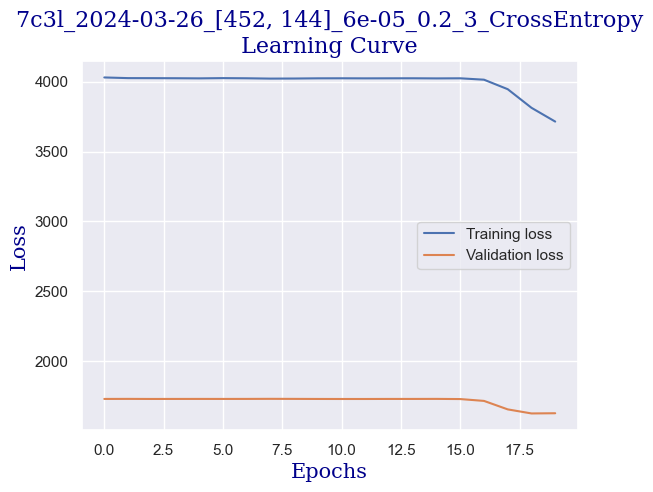

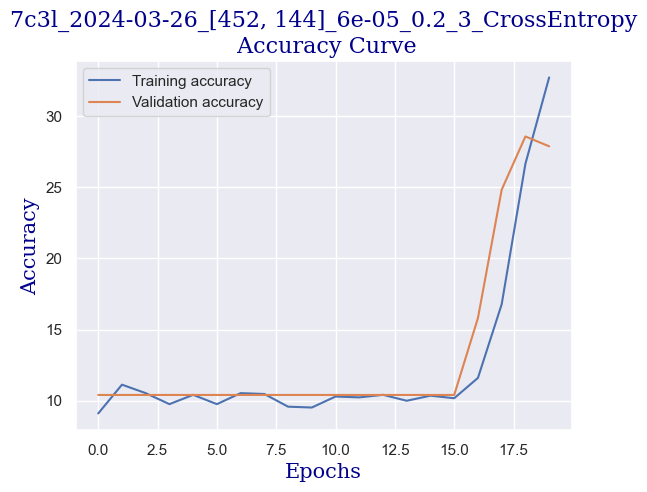

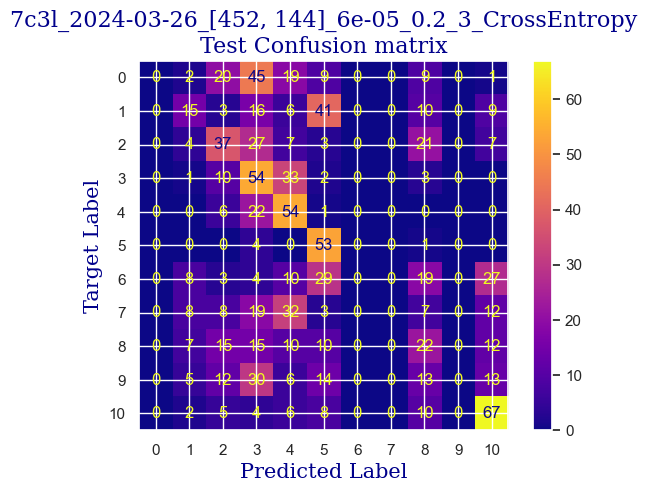

 
 END 7c3l [452, 144] Run Time:  5612.800160437997
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
101063.049691882
101050.610293455
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.339678762641284
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:15, 29.25s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.696609161213564
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:59<08:52, 29.56s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.75609756097561
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:29<08:26, 29.80s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.75609756097561
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:59<08:01, 30.12s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.696609161213564
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:30<07:33, 30.23s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.815585960737657
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [03:00<07:04, 30.30s/it]

validation accuracy:  8.876560332871012
Training...
train accuracy:  8.804283164782866
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:29<06:29, 29.98s/it]

validation accuracy:  9.70873786407767
Training...
train accuracy:  8.863771564544914
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:59<05:57, 29.77s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.458655562165378
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:28<05:25, 29.59s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.994051160023796
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:57<04:55, 29.56s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.23200475907198
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:24<04:18, 28.75s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.053539559785841
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:54<03:51, 28.94s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.458655562165378
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:23<03:23, 29.08s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  8.982748364069007
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:52<02:54, 29.12s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.39916716240333
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:22<02:26, 29.20s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.280190362879239
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:51<01:57, 29.32s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.053539559785841
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:21<01:27, 29.33s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.113027959547887
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:50<00:58, 29.29s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.220701963117191
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:19<00:29, 29.32s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.75609756097561
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:49<00:00, 29.46s/it]

validation accuracy:  9.153952843273231
Testing...


 
 train acc:  9.75609756097561
 
 val acc:  9.153952843273231
 
 test acc:  9.902912621359224


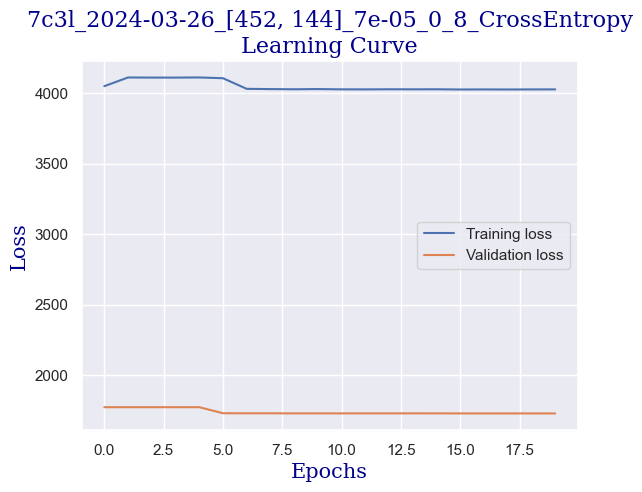

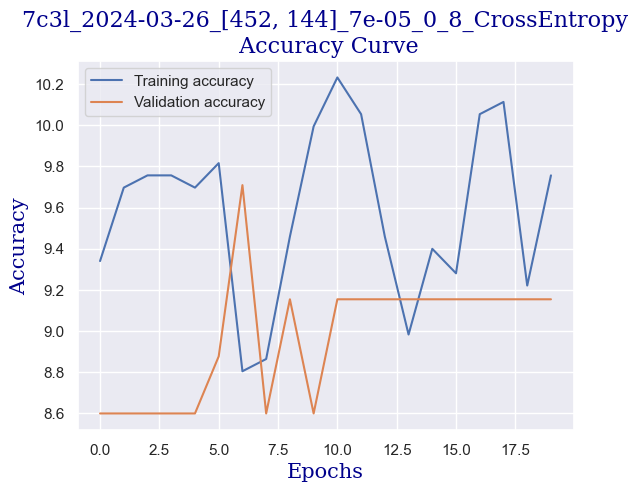

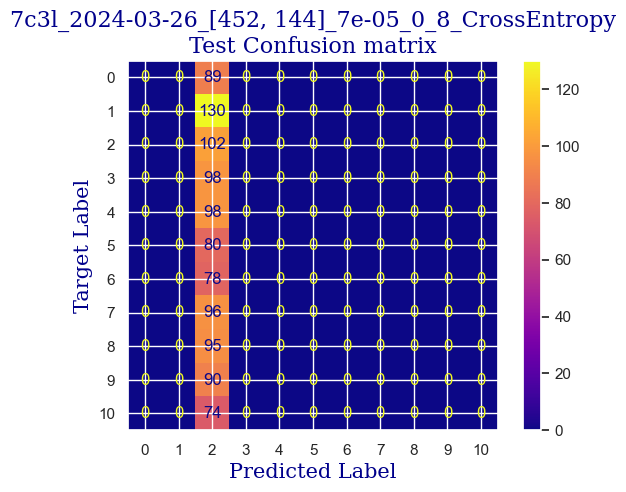

 
 END 7c3l [452, 144] Run Time:  5611.693667971005
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
106674.744635719
106662.305230043
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.042236763831053
validating...


  5%|█████▌                                                                                                          | 1/20 [00:30<09:30, 30.02s/it]

validation accuracy:  7.212205270457697
Training...
train accuracy:  9.815585960737657
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:59<08:59, 29.95s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.053539559785841
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:29<08:23, 29.60s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.945865556216537
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:58<07:52, 29.51s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.707911957168353
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:27<07:21, 29.42s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.302795954788817
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:49, 29.26s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.291493158834028
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:24<06:14, 28.80s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:53<05:47, 28.99s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:23<05:20, 29.10s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.945865556216537
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:52<04:51, 29.15s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:21<04:22, 29.14s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.23200475907198
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:50<03:53, 29.17s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:20<03:25, 29.31s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.600237953599049
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:49<02:55, 29.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.58893515764426
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:19<02:26, 29.31s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.886377156454492
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:48<01:57, 29.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.886377156454492
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:18<01:28, 29.39s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.172516359309935
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:47<00:58, 29.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:16<00:29, 29.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.421772754312908
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:45<00:00, 29.29s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  11.421772754312908
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


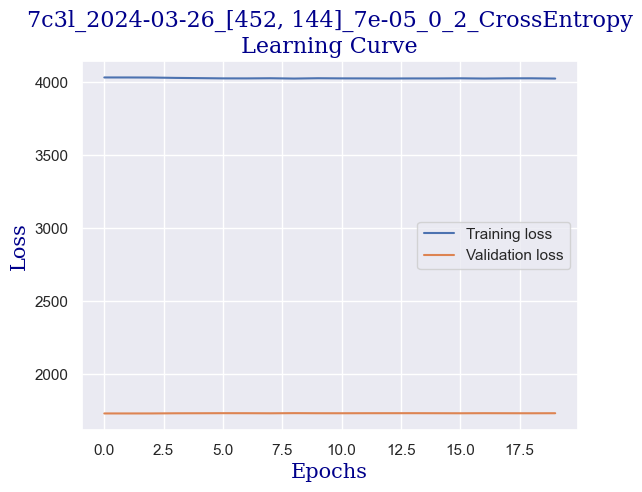

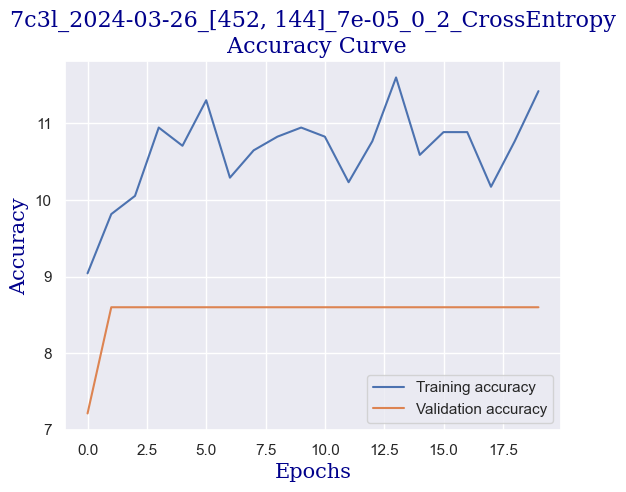

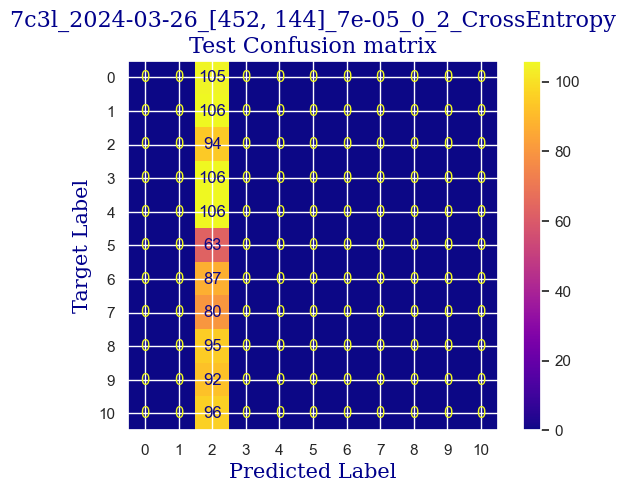

 
 END 7c3l [452, 144] Run Time:  5602.682250222992
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
112277.427958946
112264.98855617699
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  7.911957168352171
validating...


  5%|█████▌                                                                                                          | 1/20 [00:30<09:38, 30.47s/it]

validation accuracy:  9.29264909847434
Training...
train accuracy:  8.506841165972636
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:42, 29.01s/it]

validation accuracy:  9.29264909847434
Training...
train accuracy:  8.030933967876264
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:28<08:23, 29.64s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.518143961927423
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:59<07:57, 29.85s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.339678762641284
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:29<07:31, 30.11s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.291493158834028
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:59<07:02, 30.19s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.350981558596075
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:30<06:32, 30.16s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [04:00<06:02, 30.17s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.23200475907198
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:29<05:30, 30.03s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.707911957168353
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:00<05:00, 30.04s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.767400356930398
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:30<04:31, 30.13s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [06:00<04:01, 30.19s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.172516359309935
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:30<03:31, 30.20s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.350981558596075
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:01<03:01, 30.24s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.220701963117191
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:31<02:31, 30.28s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.875074360499703
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:01<02:01, 30.26s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.350981558596075
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:29<01:28, 29.54s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.23200475907198
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:00<00:59, 29.83s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.291493158834028
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:30<00:29, 29.94s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.815585960737657
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:00<00:00, 30.04s/it]

validation accuracy:  10.402219140083217
Testing...


 
 train acc:  9.815585960737657
 
 val acc:  10.402219140083217
 
 test acc:  8.058252427184467


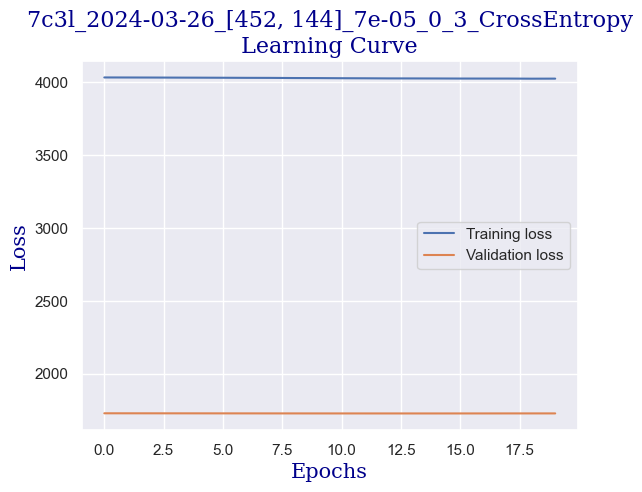

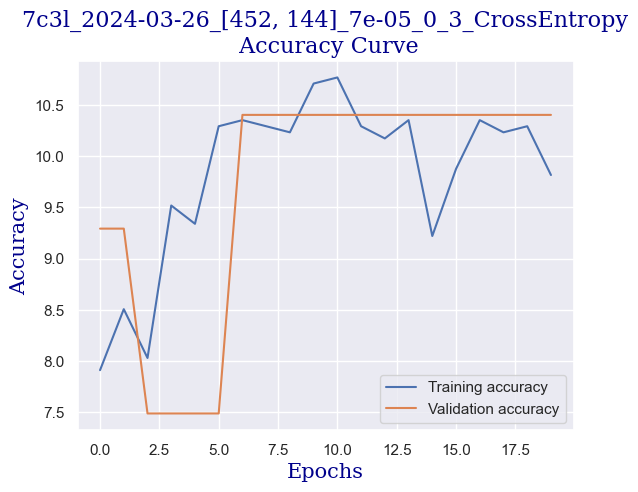

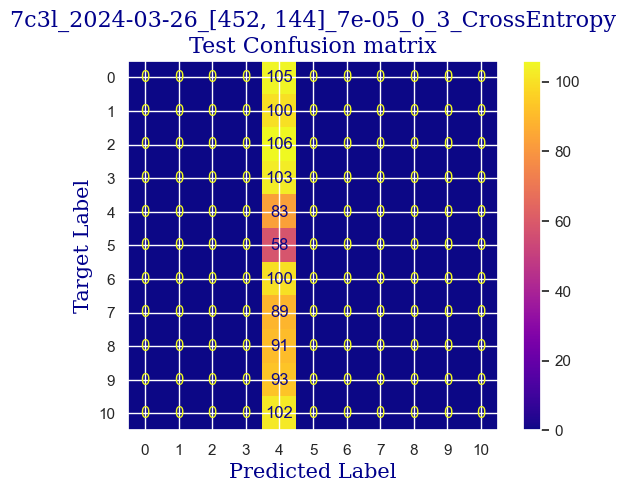

 
 END 7c3l [452, 144] Run Time:  5632.859731078992
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
117910.290163603
117897.850863256
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.625817965496728
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:18, 29.39s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  8.923259964306961
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:51, 29.51s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  8.982748364069007
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:29<08:28, 29.91s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  8.685306365258775
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:59<07:59, 29.96s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.875074360499703
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:29<07:30, 30.05s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.41046995835812
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:59<07:02, 30.15s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.767400356930398
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:30<06:31, 30.12s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [04:00<06:02, 30.23s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.469958358120167
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:31<05:34, 30.40s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:01<05:03, 30.32s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.291493158834028
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:31<04:33, 30.37s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:59<03:56, 29.60s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:30<03:28, 29.82s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:00<02:59, 29.91s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:30<02:30, 30.05s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:00<02:00, 30.09s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:31<01:30, 30.15s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:01<01:00, 30.24s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:31<00:30, 30.27s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:02<00:00, 30.10s/it]

validation accuracy:  9.153952843273231
Testing...


 
 train acc:  10.350981558596075
 
 val acc:  9.153952843273231
 
 test acc:  9.902912621359224


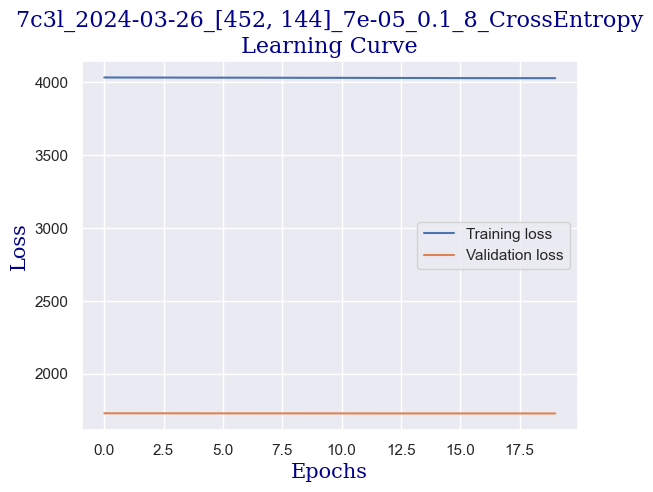

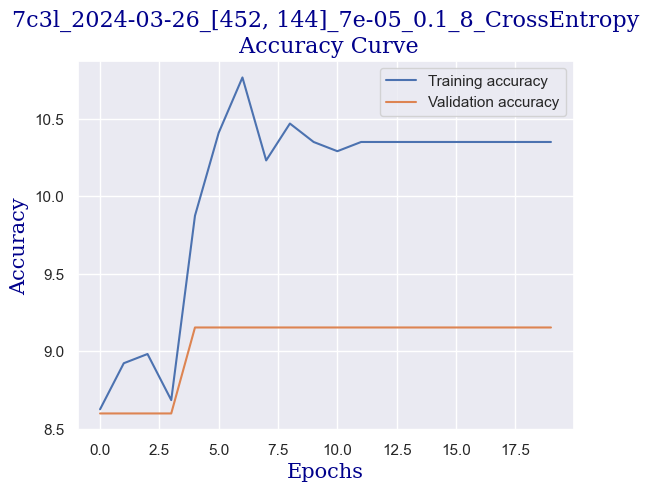

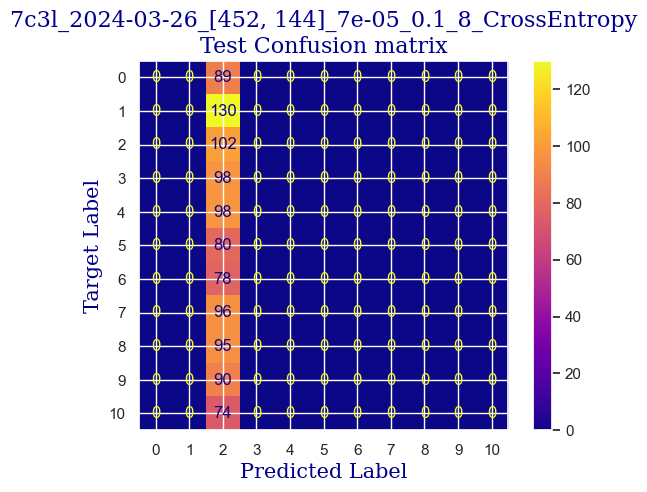

 
 END 7c3l [452, 144] Run Time:  5637.580225661004
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
123547.871668385
123535.432267484
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.982748364069007
validating...


  5%|█████▌                                                                                                          | 1/20 [00:30<09:31, 30.07s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.1017251635931
validating...


 10%|███████████▏                                                                                                    | 2/20 [01:00<09:04, 30.24s/it]

validation accuracy:  10.679611650485436
Training...
train accuracy:  9.696609161213564
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:30<08:34, 30.26s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.24330755502677
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [02:01<08:05, 30.31s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:31<07:35, 30.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [03:01<07:02, 30.15s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:30<06:26, 29.73s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [04:00<05:59, 29.95s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:31<05:31, 30.13s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:01<05:01, 30.19s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:31<04:32, 30.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [06:02<04:02, 30.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:32<03:31, 30.25s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:02<03:01, 30.24s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:32<02:31, 30.29s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:03<02:00, 30.24s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.945865556216537
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:32<01:30, 30.12s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:02<01:00, 30.10s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:32<00:30, 30.01s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.826888756692444
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:02<00:00, 30.14s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  10.826888756692444
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


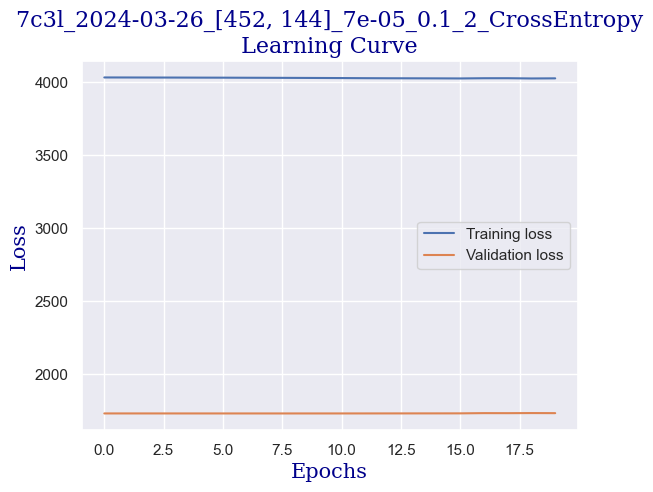

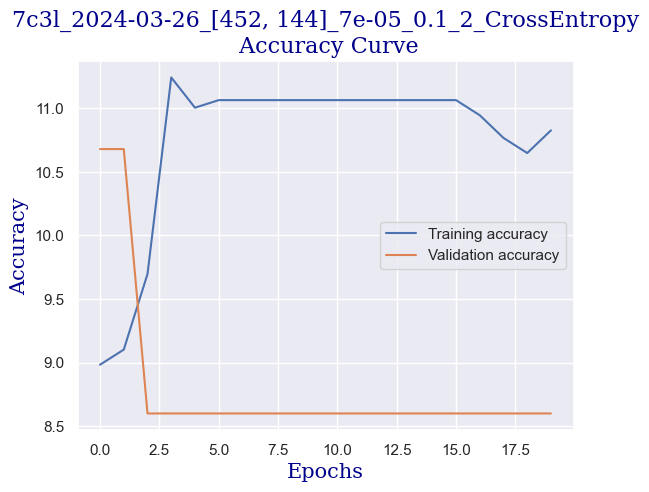

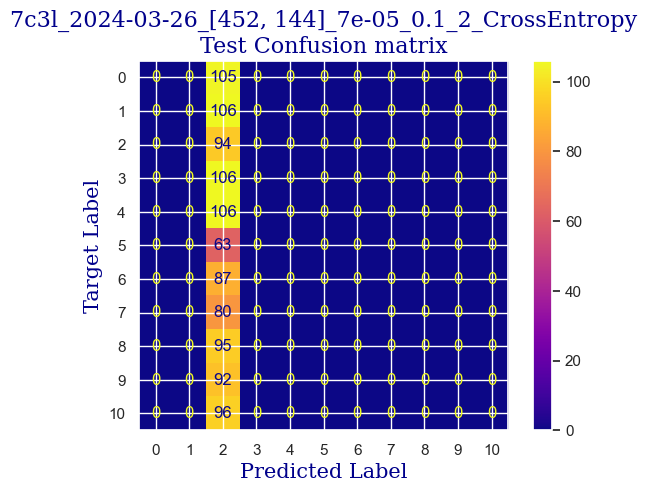

 
 END 7c3l [452, 144] Run Time:  5639.641521845988
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.1   idx: 1 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
129187.514388799
129175.074985109
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.934562760261748
validating...


  5%|█████▌                                                                                                          | 1/20 [00:27<08:36, 27.17s/it]

validation accuracy:  9.43134535367545
Training...
train accuracy:  9.39916716240333
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:56<08:31, 28.42s/it]

validation accuracy:  11.511789181692095
Training...
train accuracy:  10.529446757882214
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:25<08:09, 28.79s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.934562760261748
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:54<07:43, 28.95s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  11.183819155264723
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:24<07:15, 29.04s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  9.875074360499703
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:53<06:48, 29.18s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.458655562165378
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:22<06:20, 29.23s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  9.57763236168947
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:52<05:50, 29.24s/it]

validation accuracy:  7.489597780859916
Training...
train accuracy:  10.945865556216537
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:21<05:21, 29.22s/it]

validation accuracy:  14.701803051317613
Training...
train accuracy:  17.668054729327782
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:50<04:52, 29.30s/it]

validation accuracy:  19.694868238557557
Training...
train accuracy:  27.900059488399766
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:20<04:23, 29.29s/it]

validation accuracy:  27.323162274618586
Training...
train accuracy:  33.25401546698394
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:50<03:56, 29.52s/it]

validation accuracy:  31.761442441054093
Training...
train accuracy:  35.99048185603807
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:19<03:26, 29.50s/it]

validation accuracy:  30.374479889042995
Training...
train accuracy:  35.098155859607374
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:49<02:56, 29.49s/it]

validation accuracy:  26.49098474341193
Training...
train accuracy:  39.08387864366449
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:18<02:27, 29.45s/it]

validation accuracy:  35.64493758668516
Training...
train accuracy:  41.70136823319452
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:47<01:57, 29.40s/it]

validation accuracy:  33.56449375866852
Training...
train accuracy:  42.23676383105294
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:27, 29.10s/it]

validation accuracy:  35.78363384188627
Training...
train accuracy:  43.90243902439025
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:44<00:57, 28.90s/it]

validation accuracy:  34.535367545076284
Training...
train accuracy:  45.33016061867936
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:14<00:29, 29.15s/it]

validation accuracy:  35.78363384188627
Training...
train accuracy:  45.627602617489586
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:43<00:00, 29.19s/it]

validation accuracy:  36.89320388349515
Testing...


 
 train acc:  45.627602617489586
 
 val acc:  36.89320388349515
 
 test acc:  37.96116504854369


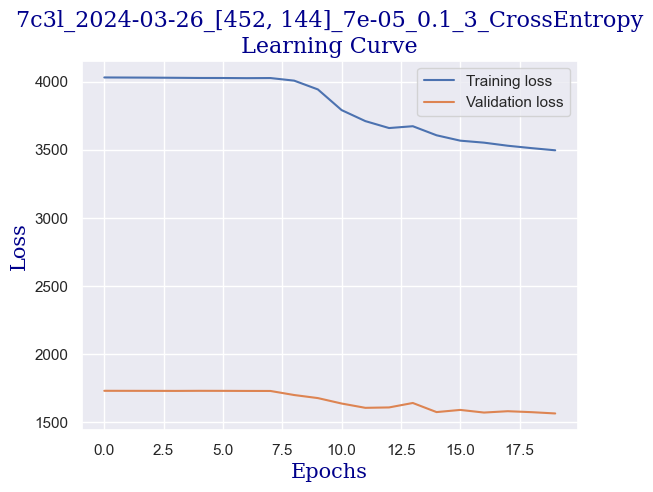

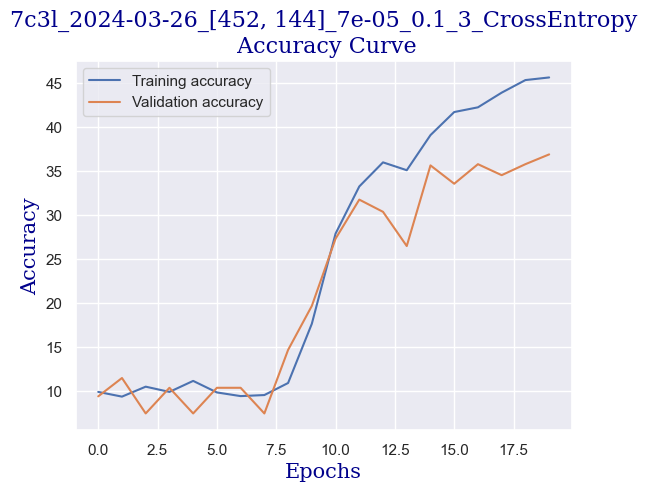

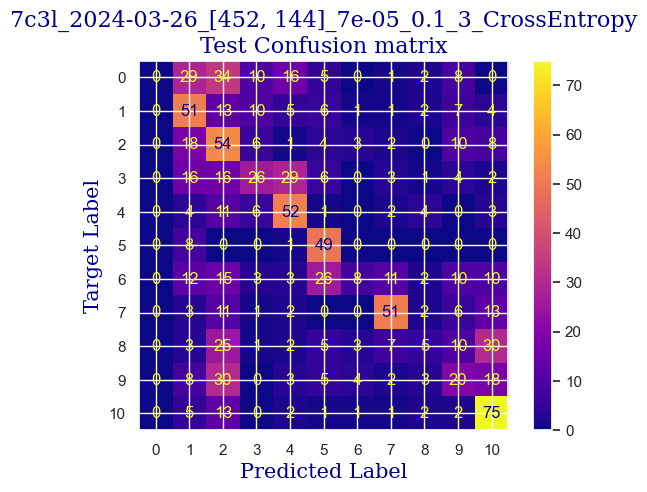

 
 END 7c3l [452, 144] Run Time:  5615.46446561499
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
134802.980247393
134790.54084490702
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.994051160023796
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:25, 29.75s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.518143961927423
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:59<08:57, 29.84s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.339678762641284
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:29<08:29, 29.99s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  11.005353955978585
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [02:00<08:02, 30.17s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:30<07:33, 30.24s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [03:01<07:04, 30.29s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:31<06:35, 30.41s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.291493158834028
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [04:02<06:04, 30.39s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.23200475907198
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:32<05:34, 30.42s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [05:02<05:03, 30.39s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:33<04:33, 30.36s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [06:00<03:56, 29.57s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:31<03:28, 29.82s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [07:01<02:59, 29.98s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:31<02:29, 29.99s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [08:01<02:00, 30.06s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:32<01:30, 30.16s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [09:02<01:00, 30.16s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:32<00:30, 30.26s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  10.350981558596075
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [10:03<00:00, 30.16s/it]

validation accuracy:  9.153952843273231
Testing...


 
 train acc:  10.350981558596075
 
 val acc:  9.153952843273231
 
 test acc:  9.902912621359224


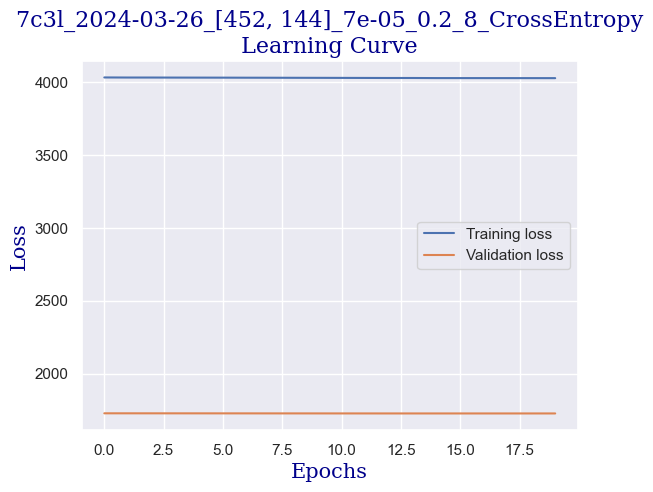

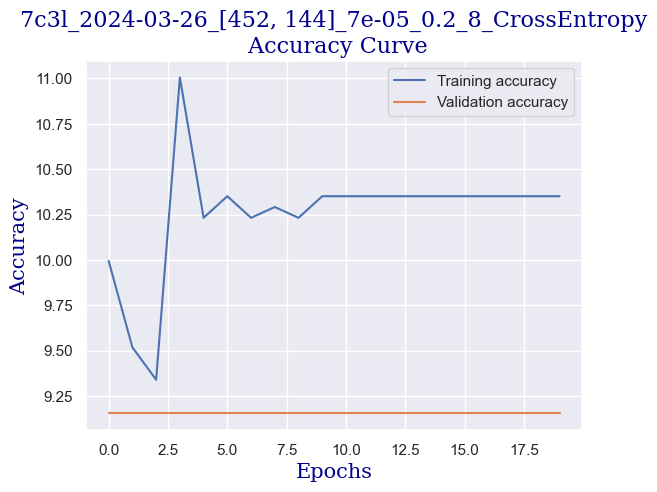

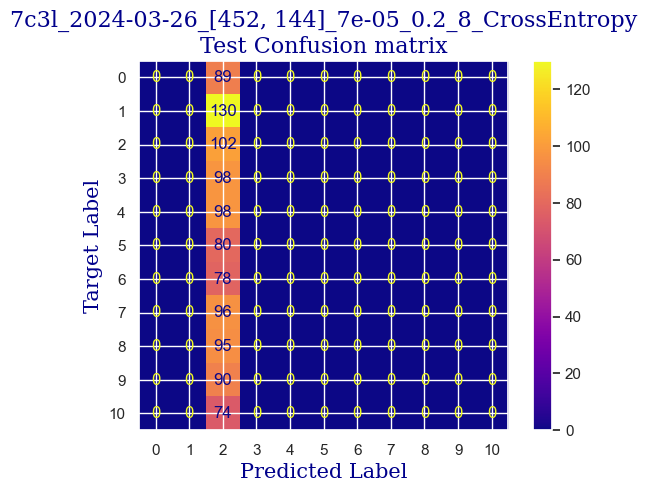

 
 END 7c3l [452, 144] Run Time:  5642.362099022022
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
140445.343722353
140432.90431819402
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  8.863771564544914
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:18, 29.39s/it]

validation accuracy:  7.212205270457697
Training...
train accuracy:  8.863771564544914
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:47, 29.29s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.350981558596075
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:18, 29.30s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.350981558596075
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:49, 29.37s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.826888756692444
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:20, 29.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.707911957168353
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:56<06:51, 29.37s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.648423557406305
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:23<06:13, 28.69s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.767400356930398
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:52<05:47, 28.96s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  12.07614515169542
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:22<05:19, 29.05s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  11.24330755502677
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:51<04:51, 29.18s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.183819155264723
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:20<04:22, 29.17s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:50<03:53, 29.23s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.23200475907198
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:19<03:24, 29.23s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.06484235574063
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:48<02:56, 29.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.124330755502678
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:18<02:26, 29.26s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.648423557406305
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:47<01:57, 29.33s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.350981558596075
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:28, 29.34s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.183819155264723
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:46<00:58, 29.33s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  11.005353955978585
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:15<00:29, 29.27s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.994051160023796
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:44<00:00, 29.23s/it]

validation accuracy:  8.599167822468793
Testing...


 
 train acc:  9.994051160023796
 
 val acc:  8.599167822468793
 
 test acc:  9.12621359223301


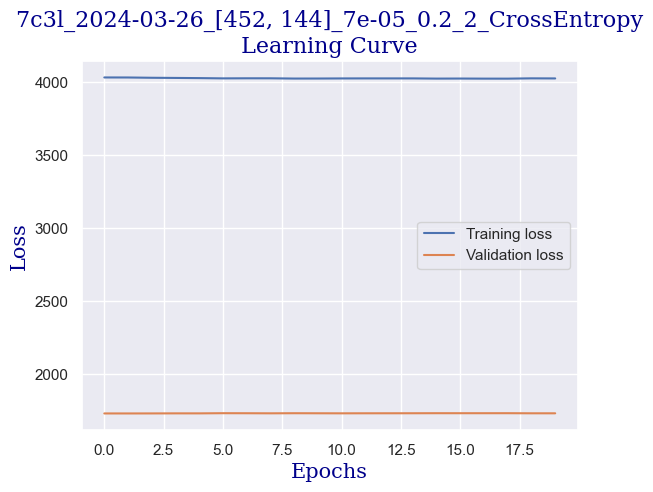

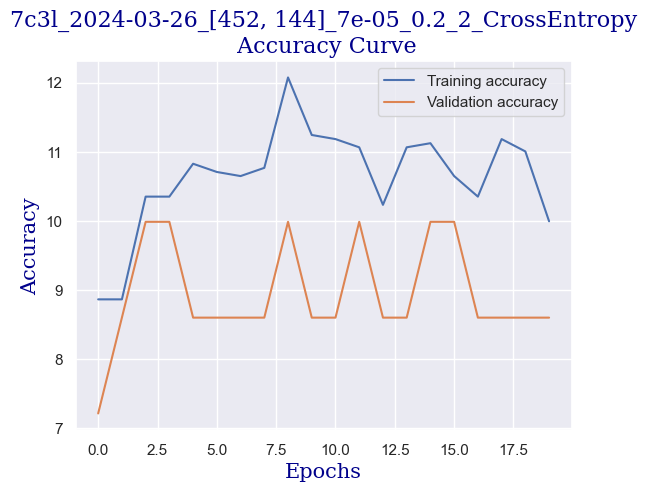

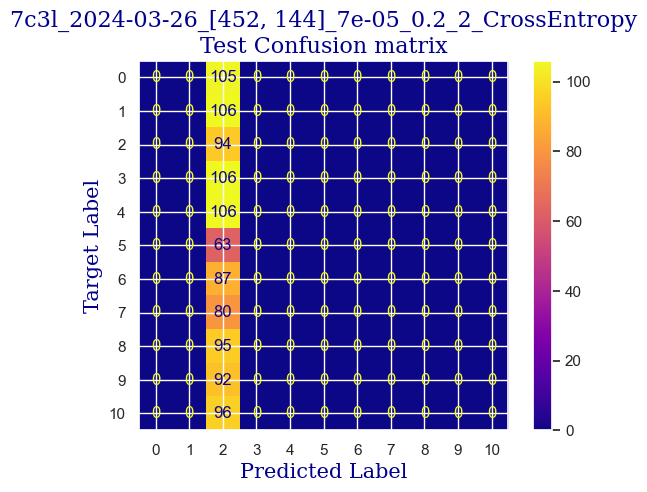

 
 END 7c3l [452, 144] Run Time:  5603.7771521820105
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  7e-05   idx: 2 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0.2   idx: 2 / 3
seed:  3   idx:  2 / 3
loss function:  CrossEntropy  idx: 0 / 1
146049.121991242
146036.682588238
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.815585960737657
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:20, 29.49s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  8.74479476502082
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:49, 29.44s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  10.350981558596075
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:25<07:59, 28.20s/it]

validation accuracy:  10.402219140083217
Training...
train accuracy:  15.466983938132065
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:54<07:37, 28.61s/it]

validation accuracy:  21.497919556171983
Training...
train accuracy:  25.580011897679956
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:23<07:11, 28.76s/it]

validation accuracy:  24.549237170596395
Training...
train accuracy:  32.123735871505055
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:53<06:45, 28.99s/it]

validation accuracy:  30.929264909847433
Training...
train accuracy:  35.99048185603807
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:22<06:18, 29.10s/it]

validation accuracy:  32.45492371705964
Training...
train accuracy:  38.48899464604402
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:51<05:50, 29.17s/it]

validation accuracy:  38.141470180305134
Training...
train accuracy:  40.63057703747769
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:21<05:20, 29.16s/it]

validation accuracy:  38.69625520110957
Training...
train accuracy:  43.01011302795955
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:50<04:51, 29.17s/it]

validation accuracy:  38.69625520110957
Training...
train accuracy:  41.58239143367044
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:19<04:23, 29.23s/it]

validation accuracy:  33.56449375866852
Training...
train accuracy:  44.6162998215348
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:49<03:54, 29.29s/it]

validation accuracy:  43.5506241331484
Training...
train accuracy:  48.66151100535396
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:18<03:25, 29.34s/it]

validation accuracy:  42.995839112343965
Training...
train accuracy:  49.01844140392623
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:47<02:56, 29.37s/it]

validation accuracy:  47.71151178918169
Training...
train accuracy:  50.20820939916716
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:17<02:26, 29.36s/it]

validation accuracy:  37.86407766990291
Training...
train accuracy:  50.32718619869125
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:46<01:57, 29.39s/it]

validation accuracy:  45.07628294036061
Training...
train accuracy:  49.494348602022605
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:16<01:28, 29.43s/it]

validation accuracy:  46.463245492371705
Training...
train accuracy:  53.42058298631767
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:45<00:58, 29.43s/it]

validation accuracy:  45.214979195561725
Training...
train accuracy:  54.43188578227246
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:12<00:28, 28.69s/it]

validation accuracy:  47.8502080443828
Training...
train accuracy:  56.454491374182034
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:41<00:00, 29.09s/it]

validation accuracy:  36.47711511789182
Testing...


 
 train acc:  56.454491374182034
 
 val acc:  36.47711511789182
 
 test acc:  32.71844660194175


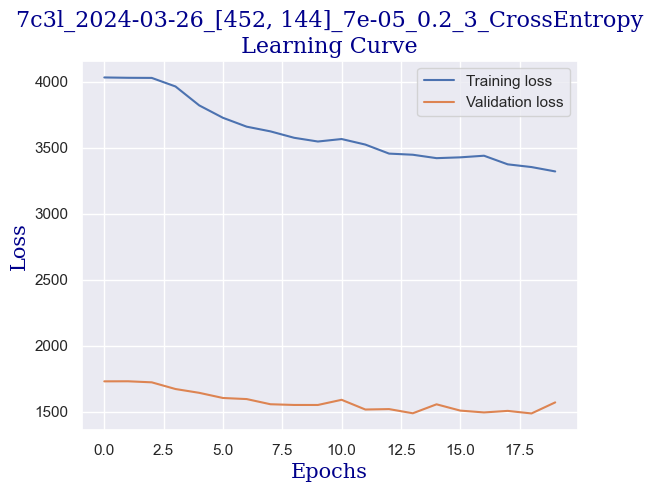

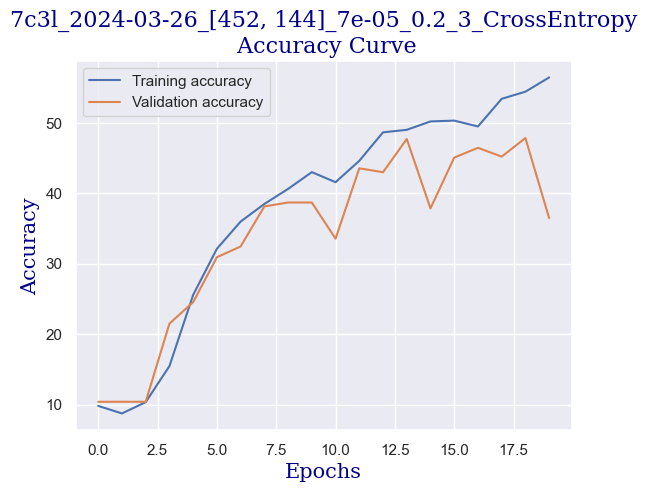

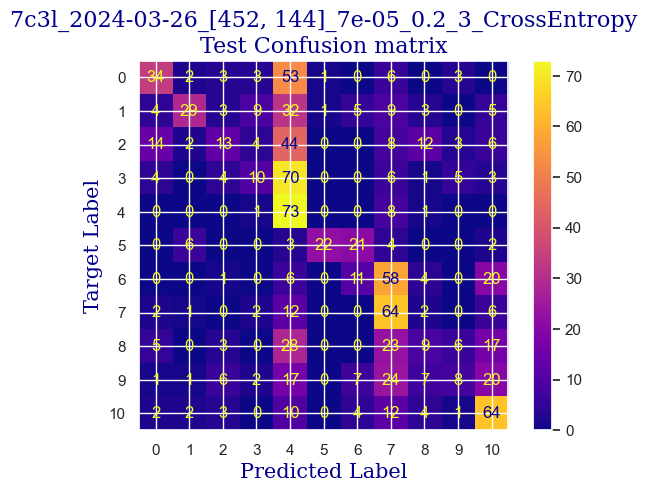

 
 END 7c3l [452, 144] Run Time:  5607.5398484450125
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  8e-05   idx: 3 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  8   idx:  0 / 3
loss function:  CrossEntropy  idx: 0 / 1
151656.662868947
151644.223478338
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.042236763831053
validating...


  5%|█████▌                                                                                                          | 1/20 [00:29<09:15, 29.24s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.57763236168947
validating...


 10%|███████████▏                                                                                                    | 2/20 [00:58<08:50, 29.46s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.57763236168947
validating...


 15%|████████████████▊                                                                                               | 3/20 [01:27<08:17, 29.25s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  10.053539559785841
validating...


 20%|██████████████████████▍                                                                                         | 4/20 [01:57<07:48, 29.31s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.339678762641284
validating...


 25%|████████████████████████████                                                                                    | 5/20 [02:26<07:19, 29.30s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  7.971445568114217
validating...


 30%|█████████████████████████████████▌                                                                              | 6/20 [02:55<06:49, 29.28s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.042236763831053
validating...


 35%|███████████████████████████████████████▏                                                                        | 7/20 [03:25<06:20, 29.30s/it]

validation accuracy:  9.153952843273231
Training...
train accuracy:  9.339678762641284
validating...


 40%|████████████████████████████████████████████▊                                                                   | 8/20 [03:54<05:52, 29.36s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.458655562165378
validating...


 45%|██████████████████████████████████████████████████▍                                                             | 9/20 [04:23<05:22, 29.30s/it]

validation accuracy:  8.599167822468793
Training...
train accuracy:  9.280190362879239
validating...


 50%|███████████████████████████████████████████████████████▌                                                       | 10/20 [04:53<04:53, 29.31s/it]

validation accuracy:  13.730929264909847
Training...
train accuracy:  23.31945270672219
validating...


 55%|█████████████████████████████████████████████████████████████                                                  | 11/20 [05:22<04:23, 29.28s/it]

validation accuracy:  16.36615811373093
Training...
train accuracy:  29.08982748364069
validating...


 60%|██████████████████████████████████████████████████████████████████▌                                            | 12/20 [05:51<03:54, 29.30s/it]

validation accuracy:  33.00970873786408
Training...
train accuracy:  34.26531826293873
validating...


 65%|████████████████████████████████████████████████████████████████████████▏                                      | 13/20 [06:21<03:25, 29.34s/it]

validation accuracy:  35.367545076282944
Training...
train accuracy:  34.91969066032124
validating...


 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 14/20 [06:50<02:55, 29.27s/it]

validation accuracy:  33.70319001386963
Training...
train accuracy:  37.06127305175491
validating...


 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 15/20 [07:17<02:23, 28.61s/it]

validation accuracy:  36.615811373092924
Training...
train accuracy:  37.9535990481856
validating...


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 16/20 [07:45<01:54, 28.64s/it]

validation accuracy:  34.812760055478506
Training...
train accuracy:  37.06127305175491
validating...


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▎                | 17/20 [08:14<01:25, 28.65s/it]

validation accuracy:  35.92233009708738
Training...
train accuracy:  39.26234384295063
validating...


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 18/20 [08:43<00:57, 28.82s/it]

validation accuracy:  38.41886269070735
Training...
train accuracy:  41.22546103509816
validating...


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 19/20 [09:12<00:28, 28.90s/it]

validation accuracy:  39.94452149791955
Training...
train accuracy:  41.22546103509816
validating...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:41<00:00, 29.09s/it]

validation accuracy:  41.33148404993065
Testing...


 
 train acc:  41.22546103509816
 
 val acc:  41.33148404993065
 
 test acc:  36.116504854368934


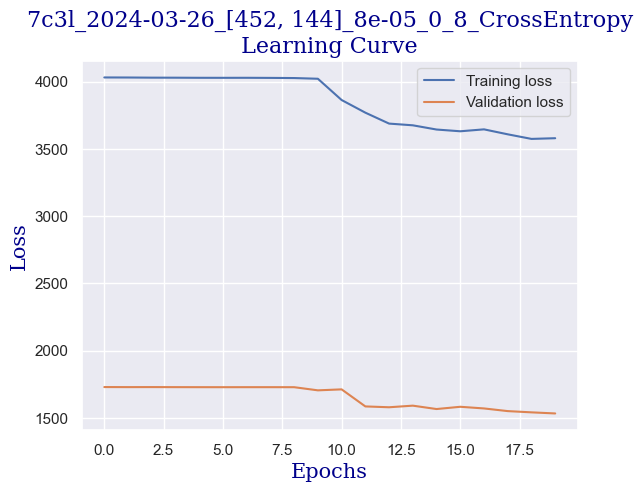

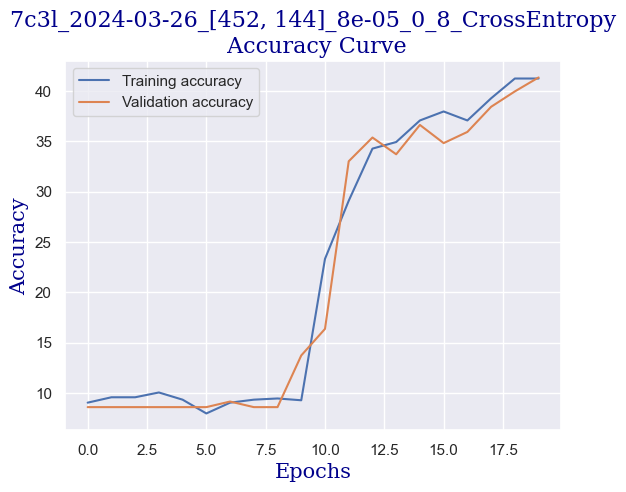

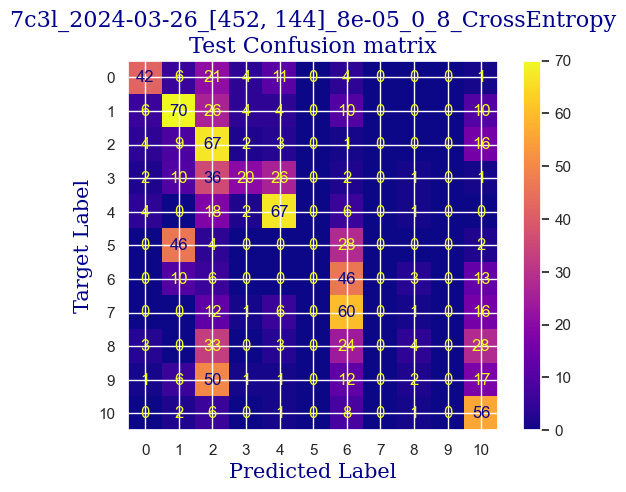

 
 END 7c3l [452, 144] Run Time:  5592.767820556008
Model:  7c3l  idx: 0 / 1
resolution:  [452, 144]   idx: 0 / 7
learning rate:  8e-05   idx: 3 / 5
weight decay:  0   idx: 0 / 1
scheduler:  0   idx: 0 / 3
seed:  2   idx:  1 / 3
loss function:  CrossEntropy  idx: 0 / 1
157249.431864859
157236.99245968703
Total epochs: 20


  0%|                                                                                                                        | 0/20 [00:00<?, ?it/s]/its/home/nn268/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Training...
train accuracy:  9.220701963117191
validating...


  5%|█████▌                                                                                                          | 1/20 [00:30<09:32, 30.12s/it]

validation accuracy:  9.986130374479888
Training...
train accuracy:  10.291493158834028
validating...


 10%|███████████▏                                                                                                    | 2/20 [01:00<09:02, 30.13s/it]

validation accuracy:  9.986130374479888
Training...


In [ ]:
_go(config)